# **Anomalous Flight Detection Using Open Source Data**

## Extracting Files ##

In [303]:
import pandas as pd
import os
import tarfile
import glob

### ONLY RUN THIS BLOCK IF YOU NEED TO EXTRACT FILES AND MAKE THEM IN TO PARQUET

# Config
TAR_DIR = r"your-directory-here"   # folder with .tar files
OUTPUT_DIR = r"your-directory-here"
EXTRACT_DIR = r"your-directory-here"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Charlotte bounding box
lat_min, lat_max = 34.714, 35.714
lon_min, lon_max = -81.443, -80.443

# Columns to keep
COLUMNS_TO_KEEP = ['icao24','callsign','time','lon','lat',
                   'baroaltitude','onground','velocity','heading','vertrate']


# Function to process one CSV file
def process_csv(file_path):
    try:
        filtered_chunks = []

        for chunk in pd.read_csv(file_path, usecols=COLUMNS_TO_KEEP, chunksize=500_000):
            mask = (chunk['latitude'].between(lat_min, lat_max)) & (chunk['longitude'].between(lon_min, lon_max))
            filtered_chunks.append(chunk[mask])

        if filtered_chunks:
            df_filtered = pd.concat(filtered_chunks)
            base_name = os.path.basename(file_path).replace(".csv", ".parquet")
            output_file = os.path.join(OUTPUT_DIR, base_name)
            df_filtered.to_parquet(output_file, engine='pyarrow', index=False)
            print(f"Saved {output_file} ({len(df_filtered)} flights)")
        else:
            print(f"No flights near Charlotte in {file_path}")
    except Exception as e:
        print(f"Failed {file_path}: {e}")


# Extract .tar files and process CSVs
for tar_name in os.listdir(TAR_DIR):
    if tar_name.endswith(".tar"):
        tar_path = os.path.join(TAR_DIR, tar_name)
        print(f"Extracting {tar_path}...")
        with tarfile.open(tar_path) as tar:
            tar.extractall(EXTRACT_DIR)
        
        # Process all CSVs in the extracted folder
        for root, dirs, files in os.walk(EXTRACT_DIR):
            for file in files:
                if file.endswith(".csv"):
                    process_csv(os.path.join(root, file))



# Find all tar files in the directory
gz_files = glob.glob(os.path.join(EXTRACT_DIR, "*.csv.tar"))
print(f"Found {len(gz_files)} tar files.")
for file in gz_files:
    try:
        df = pd.read_csv(file, compression="tar")
        parquet_path = file.replace(".csv.tar", ".parquet")
        df.to_parquet(parquet_path, index=False)
        print(f"Converted: {os.path.basename(file)} → {os.path.basename(parquet_path)}")
    except Exception as e:
        print(f"Error converting {file}: {e}")

# print("All conversions completed.")

# Save on memory by only using the relevant Charlotte flights
parquet_files = glob.glob(os.path.join(EXTRACT_DIR, "*.parquet"))
filtered_chunks = []
for file in parquet_files:
    df = pd.read_parquet(file)
    df_filtered = df[
        (df["lat"].between(lat_min, lat_max)) &
        (df["lon"].between(lon_min, lon_max))
    ]
    filtered_chunks.append(df_filtered)

# Combine only filtered parts
df_filtered_all = pd.concat(filtered_chunks, ignore_index=True)
print(f"Combined filtered DataFrame shape: {df_filtered_all.shape}")
df_filtered_all.to_csv("kclt_opensky_sept_2021_to_jun_2022.csv")



        


Found 0 tar files.


ValueError: No objects to concatenate

In [ ]:
# Scrape historical METAR data to match with flights
import requests
from bs4 import BeautifulSoup
import re
import sys

URL = ("")
HEADERS = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/120.0.0.0 Safari/537.36")
}

# Defining a function to grab the URL
def fetch(url):
    try:
        resp = requests.get(url, headers=HEADERS, timeout=20)
    except Exception as e:
        print("ERROR: network/request failed:", e, file=sys.stderr)
        return None
    print("HTTP", resp.status_code)
    if resp.status_code != 200:
        print("Response length:", len(resp.text))
        # print a bit of the returned page for debugging
        print("Page snippet:\n", resp.text[:1000])
        return None
    return resp.text

# Extract the METARS from the data
def extract_metars_from_pre(text):
    soup = BeautifulSoup(text, "html.parser")
    # find <pre> blocks
    pres = soup.find_all("pre")
    metars = []
    for p in pres:
        block = p.get_text("\n").strip()
        for line in block.splitlines():
            line = line.strip()
            if line.upper().startswith(("METAR ", "SPECI ")):
                metars.append(line)
    return metars

def extract_metars_by_regex(text):
    # Capture any line that starts with METAR or SPECI
    pattern = re.compile(r'(?m)^\s*(?:METAR|SPECI)\b.*$')
    return [m.strip() for m in pattern.findall(text)]

# Put everything together and call the main function
def main():
    html = fetch(URL)
    if not html:
        print("No HTML returned; aborting.")
        return

    metars = extract_metars_from_pre(html)
    if not metars:
        # Search raw HTML with regex if it fails for whatever reason
        metars = extract_metars_by_regex(html)

    if not metars:
        print("No METAR/SPECI lines found. Dumping a short snippet to help debug:")
        print(html[:4000])
        return

    # Print count and first 20 lines
    print(f"Found {len(metars)} METAR/SPECI lines. Showing up to first 20:\n")
    for i, line in enumerate(metars[:20], start=1):
        print(f"{i:02d}: {line}")

    # Save all to a file for later processing
    out_file = "kclt_sep_06_2021.txt"
    with open(out_file, "w", encoding="utf-8") as f:
        f.write("\n".join(metars))
    print(f"\nSaved {len(metars)} lines to {out_file}")

if __name__ == "__main__":
    main()

HTTP 200
Found 24 METAR/SPECI lines. Showing up to first 20:

01: METAR KCLT 062352Z 10004KT 10SM FEW040 FEW070 FEW120 SCT250 27/18 A2994 RMK AO2 SLP131 T02670178 10300 20267 53004 $=
02: METAR KCLT 062252Z 07004KT 10SM CLR 28/17 A2994 RMK AO2 SLP128 T02780172 $=
03: METAR KCLT 062152Z VRB03KT 10SM FEW038 FEW070 SCT110 SCT250 29/17 A2992 RMK AO2 SLP123 T02890172 $=
04: METAR KCLT 062052Z VRB05KT 10SM FEW038 SCT080 SCT130 BKN250 29/18 A2993 RMK AO2 SLP126 T02890183 56017 $=
05: METAR KCLT 061952Z 02007KT 10SM FEW030 SCT075 BKN130 BKN250 29/18 A2994 RMK AO2 SLP128 T02890183 $=
06: METAR KCLT 061852Z 01007KT 10SM FEW028 BKN070 BKN130 BKN250 28/19 A2996 RMK AO2 SLP136 T02830189 $=
07: METAR KCLT 061752Z VRB05KT 10SM FEW030 BKN065 BKN110 BKN250 27/19 A2998 RMK AO2 SLP145 60001 T02670194 10267 20222 58005 $=
08: METAR KCLT 061652Z 02007KT 10SM FEW040 BKN055 OVC100 26/20 A2999 RMK AO2 RAB1556E16 SLP147 P0000 T02610200 $=
09: METAR KCLT 061552Z 32003KT 10SM FEW040 BKN065 BKN110 OVC250 24/20 A3

In [ ]:
import re
from pathlib import Path
import pandas as pd
from metpy.io import parse_metar_to_dataframe

# Folder path
folder = Path(r"C:\Users\Rob\code_stuff\interview_pp\metar_data")  # Windows raw string

# Mapping from 3-letter month abbreviations to month numbers
MONTH_MAP = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

all_dfs = []

# Grab the files
for path in folder.glob("*.txt"):
    fname = path.stem.lower() 
    
    # Extract month abbreviation (e.g., "apr") from filename
    match = re.search(r'_(\w{3})_\d{1,2}_(\d{4})$', fname)
    if not match:
        print(f"Skipping {path.name} — name doesn't match pattern.")
        continue
    
    month_abbr, year_str = match.groups()
    month = MONTH_MAP.get(month_abbr)
    year = int(year_str)
    
    print(f"Parsing {path.name} → month={month}, year={year}")

    # Read file text
    text = path.read_text().strip()

    # Split into individual lines
    lines = [line.strip().rstrip('=') for line in text.splitlines() if line.strip()]
    
    for line in lines:
        try:
            df_block = parse_metar_to_dataframe(line, year=2022, month=month)
            df_block["source_file"] = path.name
            all_dfs.append(df_block)
        except Exception as e:
            print(f"Could not parse line in {path.name}: {line} → {e}")

# Combine all DataFrames
if all_dfs:
    df = pd.concat(all_dfs, ignore_index=True)
    print(f"\n Parsed {len(df)} total METARs from {len(all_dfs)} lines.")
else:
    df = pd.DataFrame()
    print("No valid METAR files found.")

# Save to CSV
df.to_csv("metar_combined.csv", index=False)
print("Saved to metar_combined.csv")

Parsing kclt_dec_06_2021.txt → month=12, year=2021
Parsing kclt_dec_13_2021.txt → month=12, year=2021
Parsing kclt_dec_20_2021.txt → month=12, year=2021
Parsing kclt_dec_27_2021.txt → month=12, year=2021
Parsing kclt_jun_06_2022.txt → month=6, year=2022
Parsing kclt_jun_13_2022.txt → month=6, year=2022
Parsing kclt_jun_20_2022.txt → month=6, year=2022
Parsing kclt_jun_27_2022.txt → month=6, year=2022
Parsing kclt_mar_07_2022.txt → month=3, year=2022
Parsing kclt_mar_14_2022.txt → month=3, year=2022
Parsing kclt_mar_21_2022.txt → month=3, year=2022
Parsing kclt_mar_28_2022.txt → month=3, year=2022
Parsing kclt_sep_06_2021.txt → month=9, year=2021
Parsing kclt_sep_13_2021.txt → month=9, year=2021
Parsing kclt_sep_20_2021.txt → month=9, year=2021
Parsing kclt_sep_27_2021.txt → month=9, year=2021

 Parsed 401 total METARs from 401 lines.
Saved to metar_combined.csv


In [ ]:
df.head()

station_id  latitude  longitude  elevation           date_time  \
0       KCLT     35.22     -80.95        220 2022-12-06 23:52:00   
1       KCLT     35.22     -80.95        220 2022-12-06 22:52:00   
2       KCLT     35.22     -80.95        220 2022-12-06 21:52:00   
3       KCLT     35.22     -80.95        220 2022-12-06 20:52:00   
4       KCLT     35.22     -80.95        220 2022-12-06 19:52:00   

   wind_direction  wind_speed  wind_gust  visibility current_wx1  ...  \
0           230.0        14.0       20.0    16093.44         NaN  ...   
1           220.0        12.0       19.0    16093.44         NaN  ...   
2           220.0        11.0        NaN    16093.44         NaN  ...   
3           220.0        10.0        NaN    16093.44         NaN  ...   
4           210.0        12.0        NaN    16093.44         NaN  ...   

  dew_point_temperature  altimeter current_wx1_symbol  current_wx2_symbol  \
0                  13.0      29.93                  0                   0   
1                  13.0      29.93                  0                   0   
2                  13.0      29.92                  0                   0   
3                  13.0      29.91                  0                   0   
4                  13.0      29.92                  0                   0   

  current_wx3_symbol                                 remarks  \
0                  0  AO2 SLP130 T01830133 10200 20183 51005   
1                  0                    AO2 SLP130 T01890133   
2                  0                    AO2 SLP128 T01940133   
3                  0              AO2 SLP124 T02000133 56022   
4                  0                    AO2 SLP127 T02000133   

  air_pressure_at_sea_level  eastward_wind northward_wind  \
0                   1013.50      10.724622       8.999027   
1                   1013.41       7.713451       9.192533   
2                   1013.07       7.070664       8.426489   
3                   1012.64       6.427876       7.660444   
4                   1012.98       6.000000      10.392305   

            source_file  
0  kclt_dec_06_2021.txt  
1  kclt_dec_06_2021.txt  
2  kclt_dec_06_2021.txt  
3  kclt_dec_06_2021.txt  
4  kclt_dec_06_2021.txt  

[5 rows x 32 columns]

## Flight data analysis and conversions

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import contextily as ctx
from collections import Counter


# Read in the data and wrangle it a little
df = pd.read_csv("kclt_opensky_sept_2021_to_jun_2022.csv")

# Fill in some na values
df["squawk"] = df["squawk"].fillna("Missing")
df["callsign"] = df["callsign"].fillna("Missing")
df = df.dropna()

# Convert to datetime for ease
df["datetime"] = pd.to_datetime(df["time"], unit = "s")
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["day"] = df["datetime"].dt.day

# Group flights by icao & time to find the time difference
df.sort_values(["icao24", "datetime"])
df["time_diff"] = df.groupby("icao24")["datetime"].diff().dt.total_seconds().div(60)
df["time_diff"] = df["time_diff"].fillna(0)

# Convert all metrics to ft, kts
meters_to_feet = 3.28084
meters_per_s_to_knots = 1.94384

df["baroaltitude"] = df["baroaltitude"] * meters_to_feet
df["velocity"] = df["velocity"] * meters_per_s_to_knots
df["vertrate"] = df["vertrate"] * meters_to_feet

# Calculate the distance in feet from the airport
ft_per_dg_lat = 364173.24
airport_lat, airport_lon = 35.2140, -80.9431
dlat = df['lat'] - airport_lat
dlon = df['lon'] - airport_lon
df['dist_from_KCLT_ft'] = np.sqrt(
    (dlat * ft_per_dg_lat)**2 +
    (dlon * ft_per_dg_lat * np.cos(np.radians(airport_lat)))**2
)

# Calculate the bearing to the airport
lat1 = np.radians(airport_lat)
lon1 = np.radians(airport_lon)
lat2 = np.radians(df['lat'])
lon2 = np.radians(df['lon'])

dlon = lon2 - lon1

x = np.sin(dlon) * np.cos(lat2)
y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

initial_bearing = np.degrees(np.arctan2(x, y))
df['bearing_to_airport'] = (initial_bearing + 360) % 360

# Fill in some na values
df["squawk"] = df["squawk"].fillna("Missing")
df["callsign"] = df["callsign"].fillna("Missing")
df = df.dropna()
df.info()





<class 'pandas.core.frame.DataFrame'>
Index: 2628347 entries, 0 to 2640433
Data columns (total 24 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   time                int64         
 2   icao24              object        
 3   lat                 float64       
 4   lon                 float64       
 5   velocity            float64       
 6   heading             float64       
 7   vertrate            float64       
 8   callsign            object        
 9   onground            bool          
 10  alert               bool          
 11  spi                 bool          
 12  squawk              object        
 13  baroaltitude        float64       
 14  geoaltitude         float64       
 15  lastposupdate       float64       
 16  lastcontact         float64       
 17  datetime            datetime64[ns]
 18  hour                int32         
 19  minute              int32         
 20  day    

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628347 entries, 0 to 2640433
Data columns (total 24 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   time                int64         
 2   icao24              object        
 3   lat                 float64       
 4   lon                 float64       
 5   velocity            float64       
 6   heading             float64       
 7   vertrate            float64       
 8   callsign            object        
 9   onground            bool          
 10  alert               bool          
 11  spi                 bool          
 12  squawk              object        
 13  baroaltitude        float64       
 14  geoaltitude         float64       
 15  lastposupdate       float64       
 16  lastcontact         float64       
 17  datetime            datetime64[ns]
 18  hour                int32         
 19  minute              int32         
 20  day    

In [ ]:
# Merge the two dfs on datetime to get the weather data
df_metar = pd.read_csv("metar_combined.csv")
df_metar["date_time"] = pd.to_datetime(df_metar["date_time"])
df_metar = df_metar.sort_values("date_time")
df = df.sort_values("datetime")
df_merged = pd.merge_asof(
    df,
    df_metar,
    left_on='datetime',
    right_on='date_time',
    direction='nearest',      # nearest METAR before or after
    tolerance=pd.Timedelta('1h')  # max 1 hour difference
)



In [ ]:
# Clean up the data a little more with the added METAR data

cols_to_drop = [
 # Most of these had tons of NA vlaues
        "wind_gust", 
        "current_wx1", 
        "current_wx2", 
        "current_wx3", 
        "low_cloud_type", 
        "low_cloud_level", 
        "medium_cloud_type", 
        "medium_cloud_level",
        "high_cloud_type",
        "high_cloud_level",
        "highest_cloud_type",
        "highest_cloud_level",
        "eastward_wind",
        "northward_wind",
        "source_file",
        "Unnamed: 0",
        "latitude", # These are saved in the flight data, this is duplicative
        "longitude",
]
df_merged = df_merged.drop(columns=cols_to_drop)
df_merged = df_merged.dropna()
df_merged.info()
df_merged.to_csv("kclt_opensky_and_metar_clean.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 1166662 entries, 1326311 to 2628346
Data columns (total 38 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   time                       1166662 non-null  int64         
 1   icao24                     1166662 non-null  object        
 2   lat                        1166662 non-null  float64       
 3   lon                        1166662 non-null  float64       
 4   velocity                   1166662 non-null  float64       
 5   heading                    1166662 non-null  float64       
 6   vertrate                   1166662 non-null  float64       
 7   callsign                   1166662 non-null  object        
 8   onground                   1166662 non-null  bool          
 9   alert                      1166662 non-null  bool          
 10  spi                        1166662 non-null  bool          
 11  squawk                     1166662 n

## Creating Flight Lines

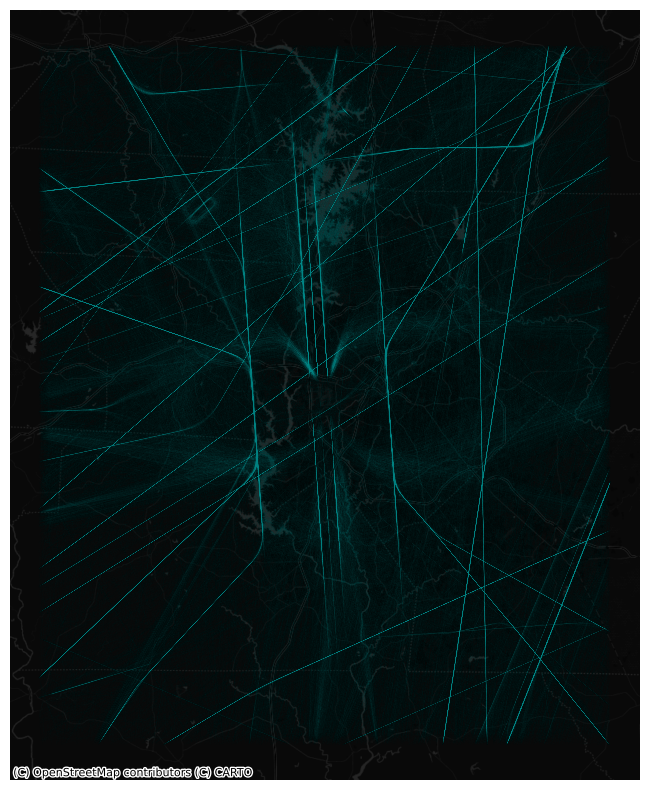

In [ ]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("kclt_opensky_and_metar_clean.csv")
# Convert to GeoDataFrame with line geometry per flight
# Save the ids and time for identifying arrivals and departures to add back to the normal df
flight_paths = []
ids = []
avg_vertrates = []
altitudes = []
start_time = []
end_time = []

# Define a time threshold of 1 hour
time_threshold = 60

for icao, icao_df in df.groupby("icao24"):
    icao_df = icao_df.sort_values("datetime").reset_index(drop=True)
    
    # Identify where the time gap exceeds an hour
    split_indices = [0]  # start of first segment
    for i, td in enumerate(icao_df["time_diff"]):
        if td > time_threshold:
            split_indices.append(i)
    split_indices.append(len(icao_df))  # end of last segment

    # Create LineStrings for each flight segment
    for start, end in zip(split_indices[:-1], split_indices[1:]):
        segment = icao_df.iloc[start:end]
        if len(segment) > 1:  # need at least 2 points for a LineString
            coords = list(zip(segment["lon"], segment["lat"], segment["baroaltitude"]))
            flight_paths.append(LineString(coords))
            ids.append(icao)
            avg_vertrates.append(segment.vertrate.mean())
            altitudes.append(segment.baroaltitude.mean()) 
            start_time.append(segment.datetime.iloc[0])
            end_time.append(segment.datetime.iloc[-1]) 

# Convert to gdf
gdf = gpd.GeoDataFrame({
    "icao24": ids,
    "avg_vertrate": avg_vertrates,
    "avg_altitude": altitudes,
    "start_time" : start_time,
    "end_time" : end_time
    }, geometry=flight_paths, crs="EPSG:4326")

# Convert to Web Mercator for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_web.plot(ax=ax, color="Cyan", alpha=0.07, linewidth=0.06)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

ax.set_axis_off()
plt.savefig("flight_paths.png", dpi=500, bbox_inches="tight", transparent=True)
plt.show()


## Attempt to define Departures, Arrivals andd Cruising flights

In [ ]:

# Define the start andd end points
def get_start_alt(geom):
    return geom.coords[0][2] if len(geom.coords[0]) > 2 else None

def get_end_alt(geom):
    return geom.coords[-1][2] if len(geom.coords[-1]) > 2 else None

gdf["alt_start"] = gdf.geometry.apply(get_start_alt)
gdf["alt_end"] = gdf.geometry.apply(get_end_alt)
gdf = gdf.dropna()


# Determine arrivals and departures
def classify_by_alt(row):
    z_start = row["alt_start"]
    z_end = row["alt_end"]
    z_rate = row["avg_vertrate"]
    # Handle missing altitudes
    if z_start is None or z_end is None:
        return "unknown"
    
    

    # Cruising: stays above 15000 ft
    if (z_start >= 15000) and (z_end >= 15000) or (abs(z_rate)<5):
        return "Cruising"
    # Arrival has a rapid descent
    elif (z_rate <= -5):
        return "Arrival"
    # Departure has a rapid ascent
    elif(z_rate >= 5):
        return "Departure"
    else:
        return "other"

# Avg vertrate within 500ft/min
gdf["flight_phase"] = gdf.apply(classify_by_alt, axis=1)
gdf.groupby("flight_phase").size()


flight_phase
Arrival      6242
Cruising     7006
Departure    5543
other        1688
dtype: int64

In [ ]:
# Save
gdf.to_csv("flight_paths.csv")

In [ ]:
# Convert to datetime and determine start times
df["datetime"] = pd.to_datetime(df["datetime"])
gdf["start_time"] = pd.to_datetime(gdf["start_time"])
gdf["end_time"] = pd.to_datetime(gdf["end_time"])

# Build flights table
flights = gdf[["icao24", "start_time", "end_time", "flight_phase"]].copy()

# Sort both by icao24 and time
df = df.sort_values("datetime").reset_index(drop=True)
flights = flights.sort_values("start_time").reset_index(drop=True)

#Had to vectorize because this took forever
merged = pd.merge_asof(
    df,
    flights,
    by="icao24",
    left_on="datetime",
    right_on="start_time",
    direction="backward",
    allow_exact_matches=True
)

mask = merged["datetime"] <= merged["end_time"]
merged.loc[~mask, "flight_phase"] = None  # points outside the segment get NaN


# print(filtered)

df = merged

# Save new df
df.head()


Unnamed: 0        time  icao24        lat        lon    velocity  \
0     1326311  1646611210  a75ac7  35.472107 -81.193757  284.423076   
1     1326335  1646611210  c06a7b  34.835738 -80.607605  448.366729   
2     1326334  1646611210  a6cffc  35.330309 -80.976426  178.473521   
3     1326333  1646611210  a13501  35.121382 -81.061592  274.234430   
4     1326332  1646611210  c05220  34.892578 -80.662365  462.086187   

      heading   vertrate  callsign  onground  ...  dew_point_temperature  \
0   98.899318  -8.533334  JIA5615      False  ...                   12.0   
1  184.477112   0.000000  TSC928       False  ...                   12.0   
2  175.822893 -13.866667  AAL830       False  ...                   12.0   
3    8.809701   1.066667  AAL1869      False  ...                   12.0   
4  178.883990   0.000000  ROU1658      False  ...                   12.0   

   altimeter current_wx1_symbol  current_wx2_symbol  current_wx3_symbol  \
0      30.19                0.0                 0.0                 0.0   
1      30.19                0.0                 0.0                 0.0   
2      30.19                0.0                 0.0                 0.0   
3      30.19                0.0                 0.0                 0.0   
4      30.19                0.0                 0.0                 0.0   

                remarks  air_pressure_at_sea_level          start_time  \
0  AO2 SLP218 T02110122                    1022.08 2022-03-07 00:00:10   
1  AO2 SLP218 T02110122                    1022.08 2022-03-07 00:00:10   
2  AO2 SLP218 T02110122                    1022.08 2022-03-07 00:00:10   
3  AO2 SLP218 T02110122                    1022.08 2022-03-07 00:00:10   
4  AO2 SLP218 T02110122                    1022.08 2022-03-07 00:00:10   

             end_time  flight_phase  
0 2022-03-07 00:12:00       Arrival  
1 2022-03-07 00:01:00      Cruising  
2 2022-03-07 00:07:00       Arrival  
3 2022-03-07 00:14:30       Arrival  
4 2022-03-07 00:01:30      Cruising  

[5 rows x 42 columns]

In [ ]:
# Save all of this for our later models
cols_to_drop = [  
        "station_id",
        "date_time",
        "remarks",
        "start_time",
        "end_time",
        "squawk",
        "callsign"
]
df_save = df.drop(columns=cols_to_drop)
df_save = df_save.dropna()
df_save.info()
df_save.to_csv("model_data.csv")


<class 'pandas.core.frame.DataFrame'>
Index: 1166612 entries, 0 to 1166661
Data columns (total 35 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Unnamed: 0                 1166612 non-null  int64         
 1   time                       1166612 non-null  int64         
 2   icao24                     1166612 non-null  object        
 3   lat                        1166612 non-null  float64       
 4   lon                        1166612 non-null  float64       
 5   velocity                   1166612 non-null  float64       
 6   heading                    1166612 non-null  float64       
 7   vertrate                   1166612 non-null  float64       
 8   onground                   1166612 non-null  bool          
 9   alert                      1166612 non-null  bool          
 10  spi                        1166612 non-null  bool          
 11  baroaltitude               1166612 non-nul

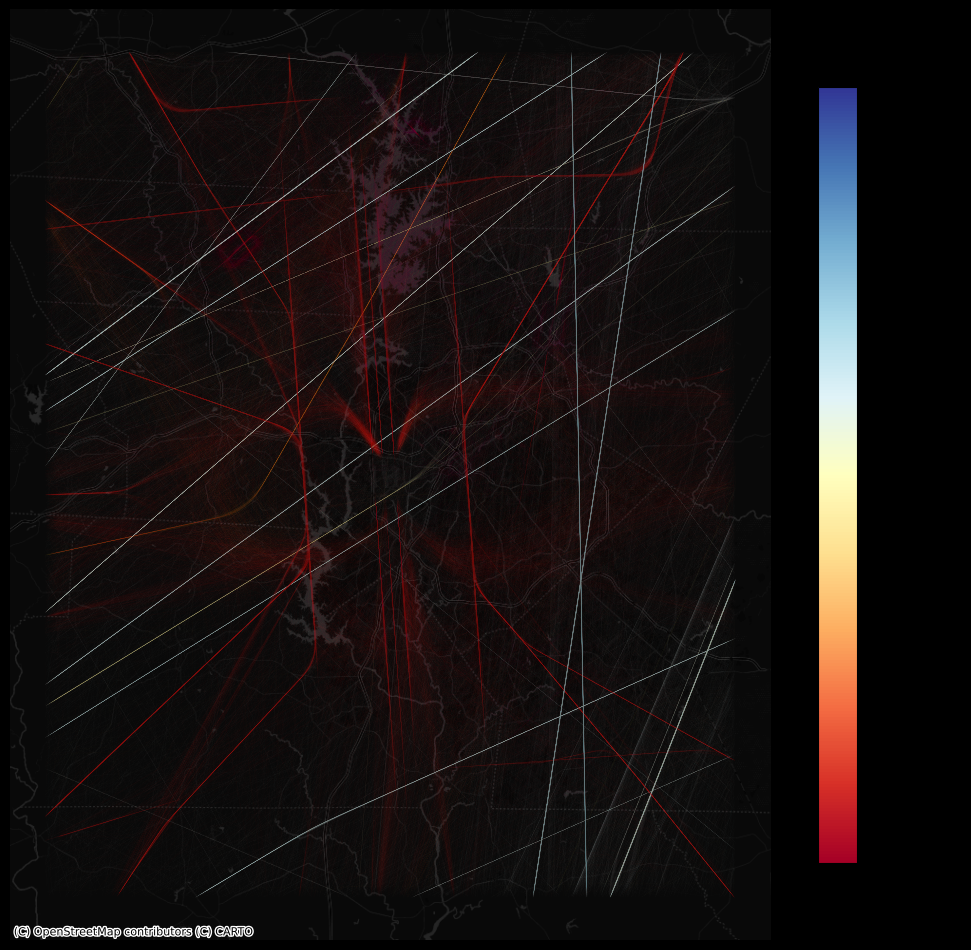

In [ ]:
# Create bins
bin_size = 100
gdf["altitude_bin"] = (gdf["avg_altitude"] // bin_size) * bin_size

# Convert to Web Mercator for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), facecolor="black")

gdf_web.plot(
    ax=ax,
    column="altitude_bin",
    cmap="RdYlBu",
    linewidth=0.08,
    alpha=0.08
)

# Add dark basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

# Create colorbar with discrete ticks for each bin
unique_bins = sorted(gdf_web["altitude_bin"].unique())
sm = plt.cm.ScalarMappable(
    cmap="RdYlBu", 
    norm=plt.Normalize(vmin=min(unique_bins), vmax=max(unique_bins))
)
sm._A = []
tick_locs = [b for b in unique_bins if b % 4000 == 0]
cbar = plt.colorbar(sm, ax=ax, ticks=tick_locs, shrink=.8)
cbar.set_label("Altitude (ft)", color="black", fontsize=20)
cbar.ax.yaxis.set_tick_params(color='black')
cbar.ax.yaxis.set_tick_params(labelcolor='black')
cbar.ax.tick_params(labelsize=14)

# Configure plot
ax.set_axis_off()
plt.tight_layout()
plt.savefig("flight_paths_by_alt.png", dpi=500, bbox_inches="tight", transparent=True)
plt.show()

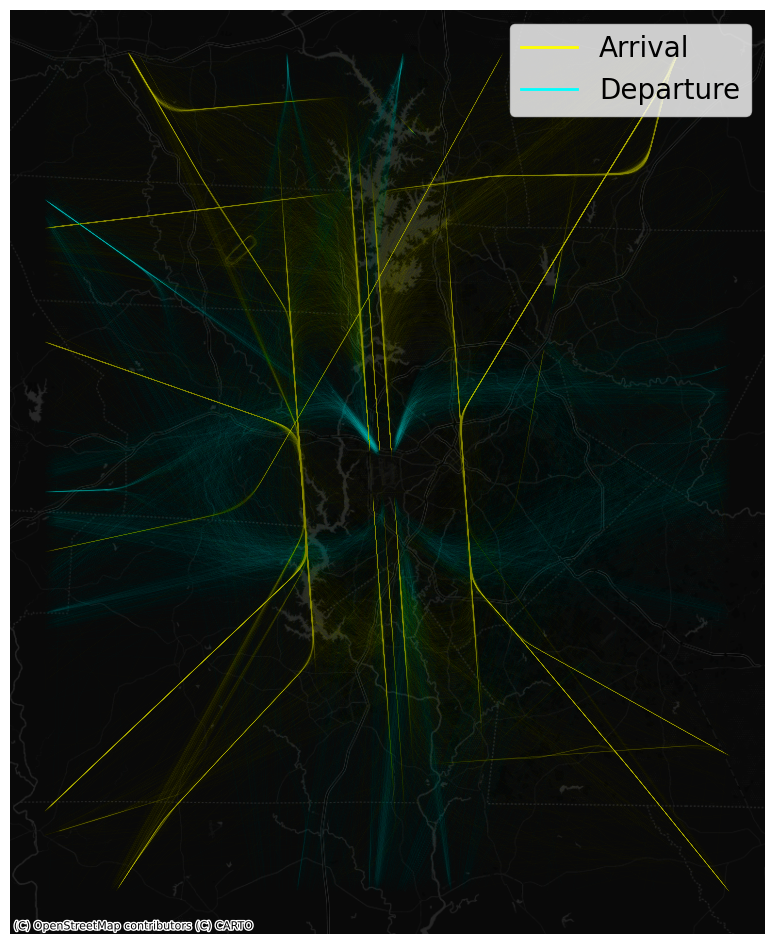

In [ ]:
# Just do arrivals and departures, get rid of cruising

# Define colors for your flight phases
phase_colors = {
    "Arrival": "yellow",
    "Departure": "cyan",
    "Cruising": "green"
}

gdf_plotting = gdf.to_crs(epsg=3857)
mask = gdf_plotting["flight_phase"].isin(["Arrival", "Departure"])
gdf_filtered = gdf_plotting[mask]
colors = gdf_filtered["flight_phase"].map(phase_colors)
# Plot the flights
ax = gdf_filtered.plot(
    figsize=(12, 12),
    linewidth=.08,  
    alpha=0.08,
    color=colors
)


# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

# Add a legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=phase) 
           for phase, color in phase_colors.items()
           if phase in ["Arrival", "Departure"]]
ax.legend(handles=handles, loc='upper right', fontsize = 20)
ax.set_axis_off()
plt.savefig("flight_paths_by_phase.png", dpi=500, bbox_inches="tight", transparent=True)

plt.show()

In [ ]:
gdf.head()


icao24  avg_vertrate  avg_altitude          start_time            end_time  \
0  06a052      0.000000  31000.000992 2022-06-13 00:16:20 2022-06-13 00:20:20   
1  06a053      0.000000  33000.001056 2022-04-18 00:07:20 2022-04-18 00:11:10   
2  06a072     -0.092754  31000.000992 2022-05-09 00:41:30 2022-05-09 00:49:00   
3  06a072      0.000000  31000.000992 2022-05-30 00:29:50 2022-05-30 00:34:00   
4  06a072      0.000000  31000.000992 2022-06-27 00:48:20 2022-06-27 00:50:20   

                                            geometry  \
0  LINESTRING Z (-81.42131 35.33082 31000.00099, ...   
1  LINESTRING Z (-81.44001 35.34581 33000.00106, ...   
2  LINESTRING Z (-81.44159 34.9044 31000.00099, -...   
3  LINESTRING Z (-81.42172 35.35754 31000.00099, ...   
4  LINESTRING Z (-81.43055 35.5005 31000.00099, -...   

                                start_point  \
0  POINT Z (-81.42131 35.33082 31000.00099)   
1  POINT Z (-81.44001 35.34581 33000.00106)   
2   POINT Z (-81.44159 34.9044 31000.00099)   
3  POINT Z (-81.42172 35.35754 31000.00099)   
4   POINT Z (-81.43055 35.5005 31000.00099)   

                                  end_point  start_dist_m    end_dist_m  \
0  POINT Z (-80.90624 35.70433 31000.00099)  55566.534678  67138.056787   
1   POINT Z (-80.8766 35.70181 33000.00106)  58163.209498  67077.166675   
2  POINT Z (-80.44344 35.40944 31000.00099)  69656.882120  61681.689787   
3  POINT Z (-80.87437 35.70309 31000.00099)  56762.330588  67279.599398   
4  POINT Z (-81.21122 35.70451 31000.00099)  66885.780687  73381.958933   

      alt_start       alt_end flight_phase  altitude_log  
0  31000.000992  31000.000992     Cruising     10.341775  
1  33000.001056  33000.001056     Cruising     10.404293  
2  31000.000992  31000.000992     Cruising     10.341775  
3  31000.000992  31000.000992     Cruising     10.341775  
4  31000.000992  31000.000992     Cruising     10.341775

## Analyzing the Data with Densities

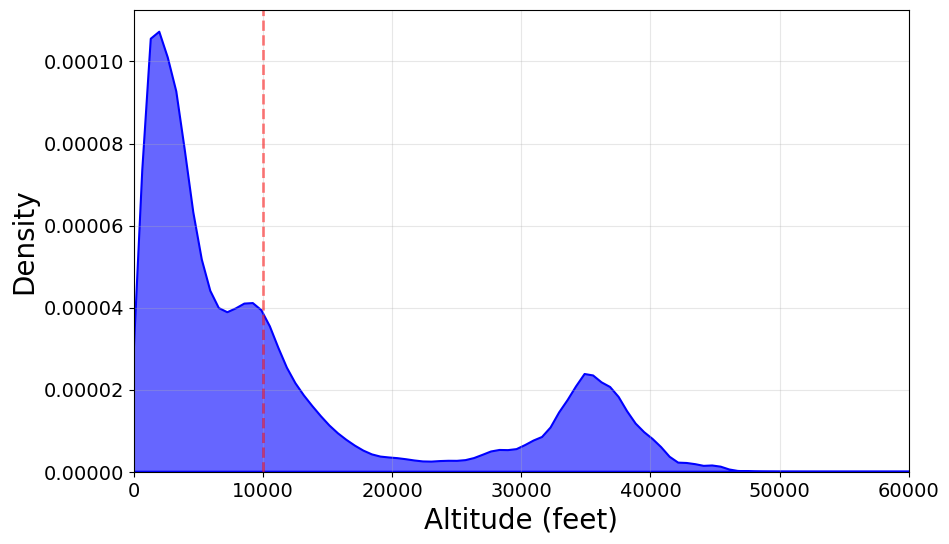

In [ ]:
import seaborn as sns

# Define a function to easily plot a bunch at once for the PP
def plot_dens(var, xlabel, xlimit):
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=df,
        x=var,      
        fill=True,
        color="blue",
        alpha=0.6,
        linewidth=1.5
    )

    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel("Density",fontsize = 20)
    plt.xlim(xlimit[0], xlimit[1])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True, alpha=0.3)

plot_dens("baroaltitude", "Altitude (feet)", (0,60000))
plt.axvline(x=10000, color="red", linestyle="--", linewidth=2, label="x = 250", alpha = .5)
plt.show()






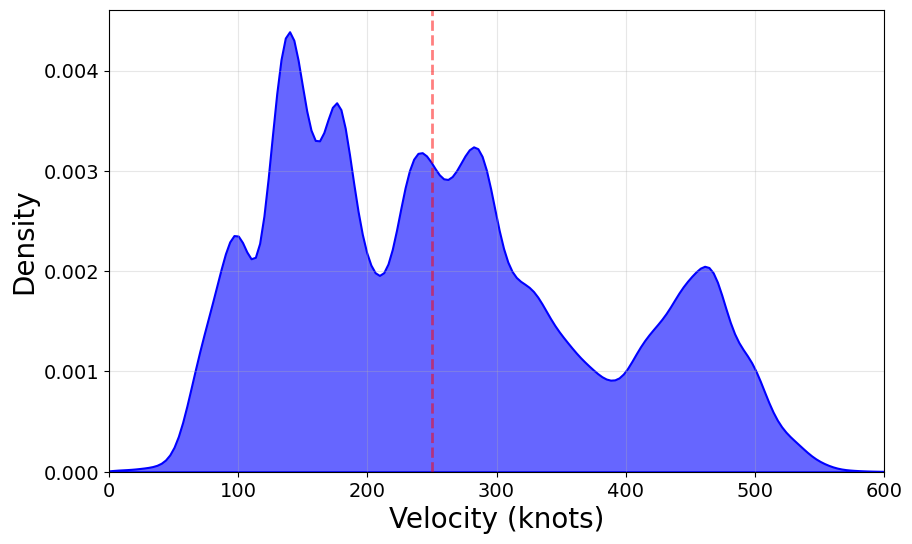

In [ ]:
plot_dens("velocity", "Velocity (knots)", (0,600))
plt.axvline(x=250, color="red", linestyle="--", linewidth=2, label="x = 250", alpha = .5)
plt.show()

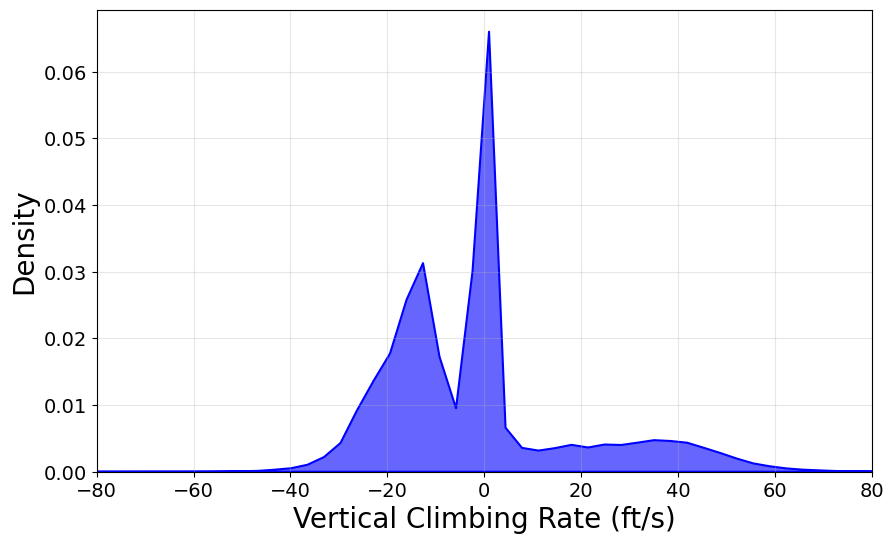

In [ ]:
plot_dens("vertrate", "Vertical Climbing Rate (ft/s)", (-80, 80))
plt.show()

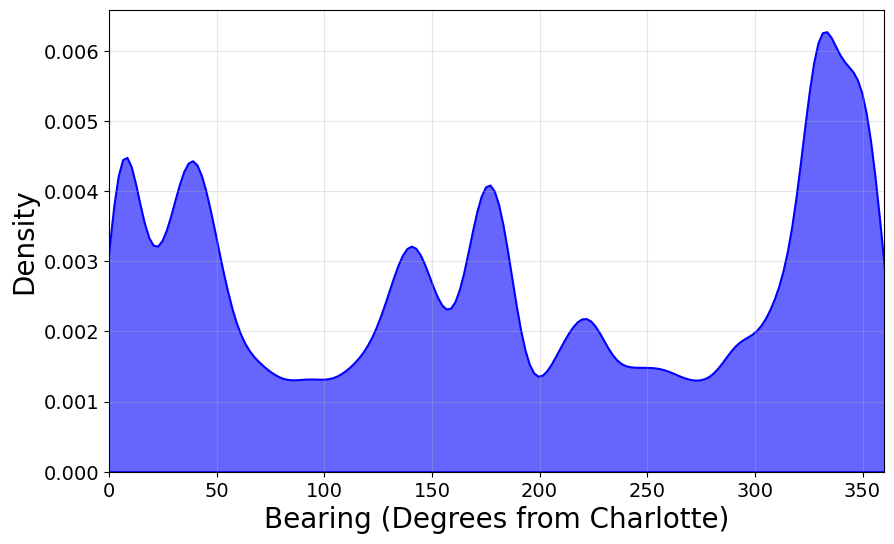

In [ ]:
plot_dens("bearing_to_airport", "Bearing (Degrees from Charlotte)",(0,360))
plt.show()

In [304]:
# df = pd.read_csv("kclt_opensky_and_metar_clean.csv")

def plot_metar(data, xlabel):

    plt.figure(figsize = (10,6))
    plt.hist(data, bins=10, color="blue", alpha=.5, edgecolor="black")
    plt.xlabel(xlabel, fontsize=24)
    plt.xticks(fontsize = 16)
    plt.yticks()
    plt.ylabel('Occurences')
    plt.show()

plot_metar(df["air_temperature"], "Temperature (Degrees Celsius)")
plot_metar(df["dew_point_temperature"], "Dew Point (Degrees Celsius)")
plot_metar(df["wind_speed"],  "Wind Speed (Knots)")
plot_metar(df["wind_direction"], "Wind Direction (Degrees from true North)")




KeyError: 'air_temperature'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166662 entries, 0 to 1166661
Data columns (total 39 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Unnamed: 0                 1166662 non-null  int64  
 1   time                       1166662 non-null  int64  
 2   icao24                     1166662 non-null  object 
 3   lat                        1166662 non-null  float64
 4   lon                        1166662 non-null  float64
 5   velocity                   1166662 non-null  float64
 6   heading                    1166662 non-null  float64
 7   vertrate                   1166662 non-null  float64
 8   callsign                   1166662 non-null  object 
 9   onground                   1166662 non-null  bool   
 10  alert                      1166662 non-null  bool   
 11  spi                        1166662 non-null  bool   
 12  squawk                     1166662 non-null  object 
 13  baroaltitude

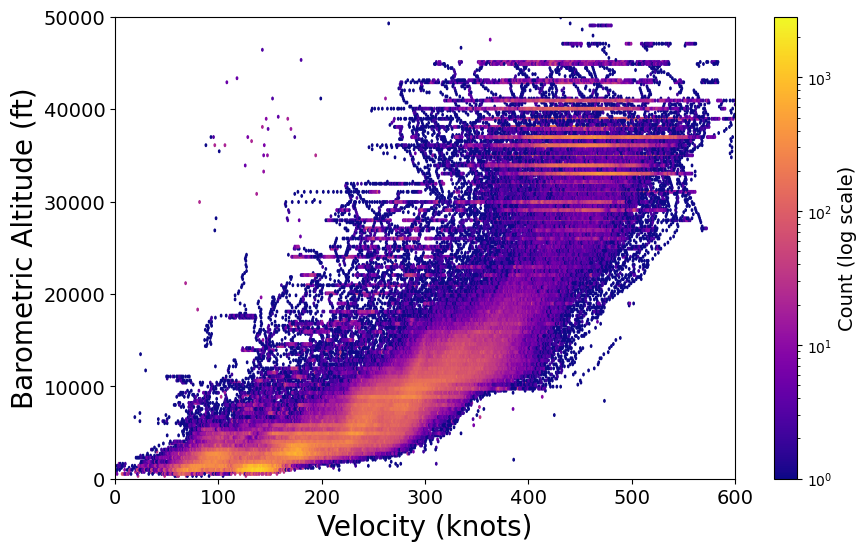

In [ ]:
# Hexbin plot of velocity and altitude
x = df['velocity']
y = df['baroaltitude']

plt.figure(figsize=(10, 6))

hb = plt.hexbin(
    x, y,
    gridsize=500,       # number of hexagons along x-axis
    cmap='plasma',
    mincnt=1,
    bins = "log"          # ignore empty bins
)
plt.colorbar(hb).set_label("Count (log scale)", size = 14)
plt.xlabel('Velocity (knots)', fontsize = 20)
plt.ylabel('Barometric Altitude (ft)', fontsize = 20)
plt.ylim(0,50000)
plt.xlim(0,600)
plt.tick_params(labelsize=14)



plt.show()


## Bayesian Network

In [ ]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import K2, HillClimbSearch, BayesianEstimator
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# Load data
bn_data = pd.read_csv("model_data.csv")
flight_df = pd.read_csv("flight_paths.csv")
bn_df = bn_data.drop(columns=[
                            # Remove unwanted columns
                            'Unnamed: 0.1',
                            'Unnamed: 0',
                            'onground', 
                            'alert', 
                            'spi', 
                            'elevation', 
                            'visibility',  
                            'current_wx2_symbol', 
                            'current_wx3_symbol',
                            'cloud_coverage',
                            'dist_from_KCLT_ft',
                            "icao24",
                            "datetime",
                            "lastcontact",
                            "lastposupdate",
                            'day',
                            'minute',
                            'hour',
                            'altimeter',
                            'air_pressure_at_sea_level',
                            'geoaltitude',
                            'time',
                            'air_temperature',
                            'time_diff'                    
])




In [ ]:
bn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166612 entries, 0 to 1166611
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   lat                    1166612 non-null  float64
 1   lon                    1166612 non-null  float64
 2   velocity               1166612 non-null  float64
 3   heading                1166612 non-null  float64
 4   vertrate               1166612 non-null  float64
 5   baroaltitude           1166612 non-null  float64
 6   bearing_to_airport     1166612 non-null  float64
 7   wind_direction         1166612 non-null  float64
 8   wind_speed             1166612 non-null  float64
 9   dew_point_temperature  1166612 non-null  float64
 10  current_wx1_symbol     1166612 non-null  float64
 11  flight_phase           1166612 non-null  object 
dtypes: float64(11), object(1)
memory usage: 106.8+ MB


In [ ]:
# Rename the weather symbols back to their discrete state
bn_df["current_wx1_symbol"].value_counts()
wx_map = {
    0: "Clear",
    17: "Fog",
    61: "Rain",
    95: "Thunderstorm",
    97: "Thunderstorm"
}

bn_df["wx_label"] = bn_df["current_wx1_symbol"].map(lambda x: wx_map.get(int(x % 100), "Unknown"))
bn_df = bn_df.drop(columns=['current_wx1_symbol'])



In [ ]:
from scipy.stats import skew
import pandas as pd

# Compute skewness for all numeric columns
skewness = bn_df.select_dtypes(include=['number']).apply(skew, nan_policy='omit')

# Sort by absolute skewness
skewness = skewness.sort_values(key=abs, ascending=False)

skew_limit = 1.0  # can adjust for stricter filter
skewed_cols = skewness[abs(skewness) > skew_limit].index.tolist()

print("Highly skewed columns:")
print(skewed_cols)

Highly skewed columns:
['baroaltitude', 'wind_speed', 'vertrate']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination

# Automatically select numeric columns except 'flight_phase'
cols_to_discretize = bn_df.select_dtypes(include=['float64', 'int64']).columns.difference(['flight_phase','wx_label'])

# Remove near-constant columns to avoid KBins warning
skewed_cols = [col for col in skewed_cols if bn_df[col].nunique() > 1]

# Initialize PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)  # Yeo-Johnson works with negative values too

# Fit and transform
bn_df[skewed_cols] = pt.fit_transform(bn_df[skewed_cols])

# Initialize KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=9, encode="ordinal", strategy="quantile")

# Fit on the data
kb.fit(bn_df[cols_to_discretize])

# Save bin edges for mapping real values to bins later
bin_edges = {col: kb.bin_edges_[i] for i, col in enumerate(cols_to_discretize)}

# Transform the data
bn_df[cols_to_discretize] = kb.transform(bn_df[cols_to_discretize])


c:\Users\Rob\anaconda3\envs\tf-gpu\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Rob\anaconda3\envs\tf-gpu\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Rob\anaconda3\envs\tf-gpu\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 9 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BIC, GES, ExpertKnowledge

expert_knowledge = ExpertKnowledge(
    # Edges that must appear in the final DAG
    required_edges=[('lat', 'bearing_to_airport'),
                    ('lon', 'bearing_to_airport'),
                    ('flight_phase', 'velocity'),
                    ('baroaltitude', 'velocity'),
                    ('vertrate','baroaltitude'),
                    ('flight_phase', 'baroaltitude'),
                    ('flight_phase', 'vertrate')
                    
    ],
    
    # Edges that must not appear
    forbidden_edges=[

    # Heading effects
    ('heading', 'baroaltitude'),
    ('heading', 'vertrate'),
    ('bearing_to_airport','dew_point_temperature'), 

    # Baroaltitude effects
    ('baroaltitude', 'flight_phase'),
    ('baroaltitude', 'velocity'),

    # Wind effects
    ('wind_direction', 'lat'),
    ('wind_direction', 'lon'),
    ('wind_speed', 'lat'),
    ('wind_speed', 'lon'),

    # Dew point / weather effects
    ('dew_point_temperature', 'lon'),
    ('dew_point_temperature', 'lat')
    ],
    
    # Order that edges must appear in
    temporal_order=[
    ('dew_point_temperature', 'wind_direction', 'wind_speed', 'wx_label'),  # weather first, label last
    ('lat', 'lon', 'bearing_to_airport'),  # position
    ('flight_phase', 'baroaltitude', 'vertrate', 'velocity'),  # flight dynamics
    ('heading',)  # heading last
]
)

hc = GES(bn_df)
dag = hc.estimate(scoring_method=BIC(bn_df), expert_knowledge=expert_knowledge)

bn_model = DiscreteBayesianNetwork(dag.edges())
bn_model.fit(bn_df, estimator=MaximumLikelihoodEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'lat': 'N', 'lon': 'N', 'velocity': 'N', 'heading': 'N', 'vertrate': 'N', 'baroaltitude': 'N', 'bearing_to_airport': 'N', 'wind_direction': 'N', 'wind_speed': 'N', 'dew_point_temperature': 'N', 'flight_phase': 'C', 'wx_label': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'lat': 'N', 'lon': 'N', 'velocity': 'N', 'heading': 'N', 'vertrate': 'N', 'baroaltitude': 'N', 'bearing_to_airport': 'N', 'wind_direction': 'N', 'wind_speed': 'N', 'dew_point_temperature': 'N', 'flight_phase': 'C', 'wx_label': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'lat': 'N', 'lon': 'N', 'velocity': 'N', 'heading': 'N', 'vertrate': 'N', 'baroaltitude': 'N', 'bearing_to_airport': 'N', 'wind_direction': 'N', 'wind_speed': 'N', 'dew_point_temperature': 'N', 'flight_phase': 'C', 'wx

MemoryError: Unable to allocate 2.99 GiB for an array with shape (3214155168,) and data type int8

In [ ]:
# Save the BN
import pickle

with open("bn_model.pkl", "wb") as f:
    pickle.dump(bn_model, f)

In [ ]:
bn_model.nodes

NodeView(('lat', 'bearing_to_airport', 'velocity', 'heading', 'baroaltitude', 'flight_phase', 'vertrate', 'lon', 'wind_direction', 'wind_speed', 'dew_point_temperature', 'wx_label'))

In [ ]:
# Define a function that can map the real values of a flight to their corresponding bins
import warnings
infer = VariableElimination(bn_model)


def map_to_bin(col, value):
    warnings.filterwarnings("ignore", category=UserWarning)
    if col in cols_to_discretize:
        # Transform value only if column was included in PowerTransformer
        if col in skewed_cols:
            # Create placeholder for all skewed features (same length as fit)
            tmp = np.zeros((1, len(skewed_cols)))
            col_idx_skewed = list(skewed_cols).index(col)
            tmp[0, col_idx_skewed] = value

            # Transform and extract the corresponding transformed value
            val_t = pt.transform(tmp)[0, col_idx_skewed]
        else:
            val_t = value  # leave untouched if not skewed
        
        # Use KBinsDiscretizer bin edges for this column
        col_idx = list(cols_to_discretize).index(col)
        edges = kb.bin_edges_[col_idx]
        bin_idx = np.digitize(val_t, edges[1:-1])
        return np.clip(bin_idx, 0, len(edges)-2)
    else:
        return value  # categorical or excluded variables


# Define evidence using raw values
evidence = {
    'velocity': map_to_bin('velocity', 450),
    'vertrate': map_to_bin('vertrate', 0),
    'baroaltitude': map_to_bin('baroaltitude', 35000),
    
}

query_result = infer.query(variables=["flight_phase"], evidence=evidence)
print(query_result)


+-------------------------+---------------------+
| flight_phase            |   phi(flight_phase) |
+=========================+=====================+
| flight_phase(Arrival)   |              0.0019 |
+-------------------------+---------------------+
| flight_phase(Cruising)  |              0.9978 |
+-------------------------+---------------------+
| flight_phase(Departure) |              0.0003 |
+-------------------------+---------------------+


In [ ]:
# Load data
bn_data = pd.read_csv("model_data.csv")
bn_data = bn_data.drop(columns=[
                            # Remove unwanted columns
                            'Unnamed: 0.1',
                            'Unnamed: 0',
                            'onground', 
                            'alert', 
                            'spi', 
                            'elevation', 
                            'visibility',  
                            'current_wx2_symbol', 
                            'current_wx3_symbol',
                            'cloud_coverage',
                            'dist_from_KCLT_ft',
                            "icao24",
                            "datetime",
                            "lastcontact",
                            "lastposupdate",
                            'day',
                            'minute',
                            'hour',
                            'altimeter',
                            'air_pressure_at_sea_level',
                            'geoaltitude',
                            'time',
                            'air_temperature',
                            'time_diff'  
]
)


In [ ]:
import pickle

# Load your model
with open("bn_model.pkl", "rb") as f:
    bn_model = pickle.load(f)

# model.edges() gives parent → child relationships
edges = list(bn_model.edges())
print("Dependencies (Parent -> Child):")
for parent, child in edges:
    print(f"{parent} -> {child}")

Dependencies (Parent -> Child):
lat -> bearing_to_airport
lat -> velocity
lat -> baroaltitude
lat -> vertrate
lat -> flight_phase
lat -> lon
bearing_to_airport -> heading
velocity -> baroaltitude
velocity -> heading
vertrate -> flight_phase
flight_phase -> velocity
flight_phase -> heading
flight_phase -> baroaltitude
lon -> bearing_to_airport
lon -> velocity
lon -> baroaltitude
lon -> vertrate
lon -> heading
lon -> flight_phase
wind_direction -> vertrate
wind_direction -> wx_label
wx_label -> lon
wx_label -> lat
wind_speed -> wind_direction
wind_speed -> dew_point_temperature
wind_speed -> wx_label
dew_point_temperature -> velocity
dew_point_temperature -> wind_direction
dew_point_temperature -> wx_label


In [ ]:
from scipy.stats import entropy

bn_data["datetime"] = pd.to_datetime(bn_data["datetime"])



# Filter flight
icao24 = '06a052'
start_time = "2022-06-13 00:16:20"
end_time = "2022-06-13 00:20:20"

flight_df = bn_data[
    (bn_data['icao24'] == icao24) &
    (bn_data["datetime"] >= start_time) &
    (bn_data["datetime"] <= end_time)
].sort_values("datetime").reset_index(drop=True)


# Take last row, modify, and append
last_row = flight_df.iloc[-1].copy()
last_row["velocity"] = last_row["velocity"] - 500
last_row["datetime"] = last_row["datetime"] + pd.Timedelta(seconds=10)

flight_df = pd.concat([flight_df, last_row.to_frame().T], ignore_index=True)

flight_df = flight_df.drop(columns=[
                            # Remove unwanted columns
                            'Unnamed: 0.1',
                            'Unnamed: 0','onground', 
                            'alert', 'spi', 'elevation', 
                            'visibility', 'current_wx1_symbol', 
                            'current_wx2_symbol', 
                            'current_wx3_symbol',
                            'cloud_coverage',
                            'dist_from_KCLT_ft'
                            
])
                        
flight_df["datetime"] = pd.to_datetime(flight_df["datetime"])
flight_df.tail()


time  icao24        lat        lon   velocity    heading vertrate  \
21  1655079590  06a052  35.655709 -80.969005  506.44681  46.440093      0.0   
22  1655079600  06a052  35.672049 -80.947967  507.17193  46.517943      0.0   
23  1655079610  06a052  35.688034 -80.927296  507.17193  46.517943      0.0   
24  1655079620  06a052   35.70433 -80.906239  507.17193  46.517943      0.0   
25  1655079620  06a052   35.70433 -80.906239    7.17193  46.517943      0.0   

    baroaltitude geoaltitude   lastposupdate  ... day time_diff  \
21  31000.000992     9966.96  1655079589.563  ...  13  0.166667   
22  31000.000992     9966.96  1655079599.808  ...  13  0.166667   
23  31000.000992     9966.96  1655079609.687  ...  13  0.166667   
24  31000.000992     9966.96  1655079619.787  ...  13  0.166667   
25  31000.000992     9966.96  1655079619.787  ...  13  0.166667   

   bearing_to_airport wind_direction wind_speed air_temperature  \
21         357.271795            0.0        0.0            28.0   
22         359.505452            0.0        0.0            28.0   
23           1.551145            0.0        0.0            28.0   
24           3.493373            0.0        0.0            28.0   
25           3.493373            0.0        0.0            28.0   

   dew_point_temperature altimeter air_pressure_at_sea_level flight_phase  
21                  19.0     29.93                   1012.64     Cruising  
22                  19.0     29.93                   1012.64     Cruising  
23                  19.0     29.93                   1012.64     Cruising  
24                  19.0     29.93                   1012.64     Cruising  
25                  19.0     29.93                   1012.64     Cruising  

[5 rows x 24 columns]

In [ ]:
# Create a fake flight to demonstrate the rapid change in out anomaly score
import pandas as pd

n_maintain = 60      # steps maintaining altitude
n_fall = 60           # steps in dive
alt_start = 40000
v_start = 500     # starting altitude in ft
dv = 10
dt = 1               # time step in seconds
vertrate = -400



# Velocity
dummy_flight_1 = pd.DataFrame(columns = bn_df.columns)   
dummy_flight_1["velocity"] = [500] *(n_maintain + n_fall) 

# Vertical rate - flight just dive bombs
dummy_flight_1["vertrate"] = ([0] * n_maintain) + ([vertrate] * n_fall)


# Altitude
alt_end = []
for i in range(n_fall):
    alt_end.append(alt_start + (vertrate * i))
dummy_flight_1["baroaltitude"] = [alt_start] * (n_maintain) + alt_end
dummy_flight_1['flight_phase'] = 'Cruising'
dummy_flight_1['wx_label'] = 'Clear'
dummy_flight_1['bearing_to_airport'] = 0


In [ ]:
from pgmpy.inference import VariableElimination


# Make a function that can compute the joint probability
evidence_cols = ['baroaltitude', 'vertrate', 'flight_phase', 'velocity']

epsilon = 1e-12  # to avoid log(0)

# Initialize inference object
infer = VariableElimination(bn_model)

def compute_anomaly_score(row):
    joint_prob = 1.0

    for var in evidence_cols:
        val = row[var]

        # Map to bin
        bin_value = map_to_bin(var, val)

        # Build evidence excluding current variable
        other_evidence = {v: map_to_bin(v, row[v]) for v in evidence_cols if v != var}

        # Query probability of current variable given other evidence
        res = infer.query(variables=[var], evidence=other_evidence)

        # Find the index of the bin value in the CPD states
        try:
            state_idx = res.state_names[var].index(bin_value)
        except ValueError:
            # If somehow the value is outside known bins, assign a very small probability
            joint_prob *= epsilon
            continue

        joint_prob *= res.values[state_idx]

    return -np.log(joint_prob + epsilon)
# Apply to each row
dummy_flight_1['anomaly_score'] = dummy_flight_1.apply(compute_anomaly_score, axis=1)

In [ ]:
# 50k row sample for estimate on density
bn_sample = bn_data.sample(5000)

bn_sample['anomaly_score'] = bn_sample.apply(compute_anomaly_score, axis=1)

In [ ]:
bn_sample["anomaly_score"].max()


21.191280947045843

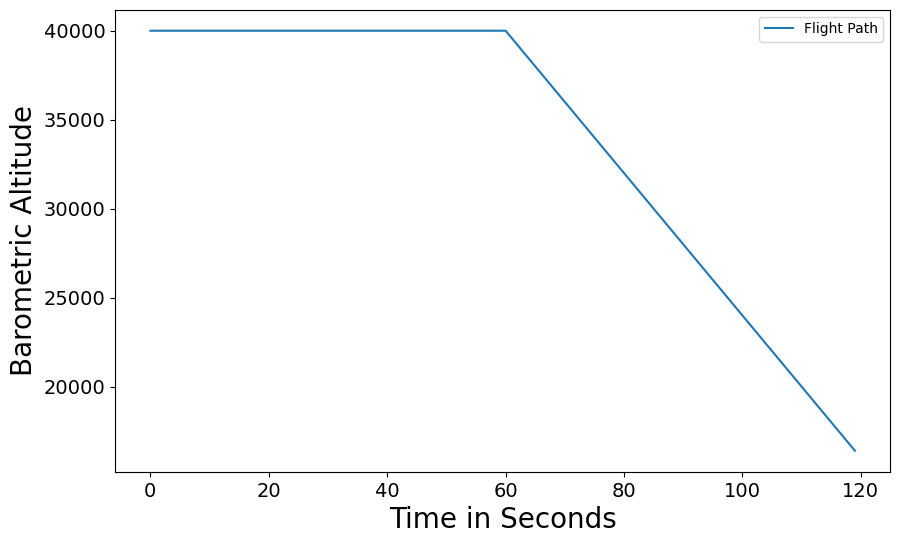

In [ ]:
import matplotlib.pyplot as plt

# Plot the flight path
time  = range(120)
plt.figure(figsize=(10, 6))
plt.plot(time, dummy_flight_1["baroaltitude"], label = "Flight Path")
plt.ylabel("Barometric Altitude", fontsize = 20)
plt.xlabel("Time in Seconds", fontsize = 20)
plt.tick_params(labelsize = 14)
plt.legend()


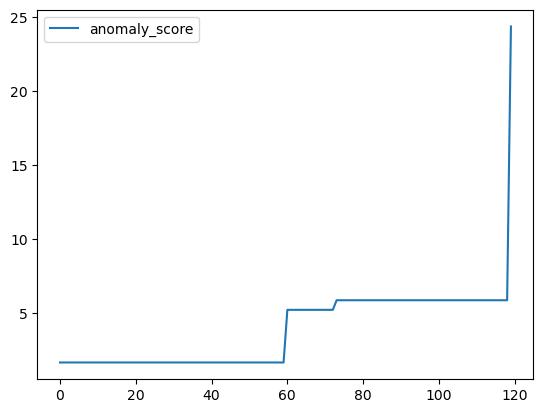

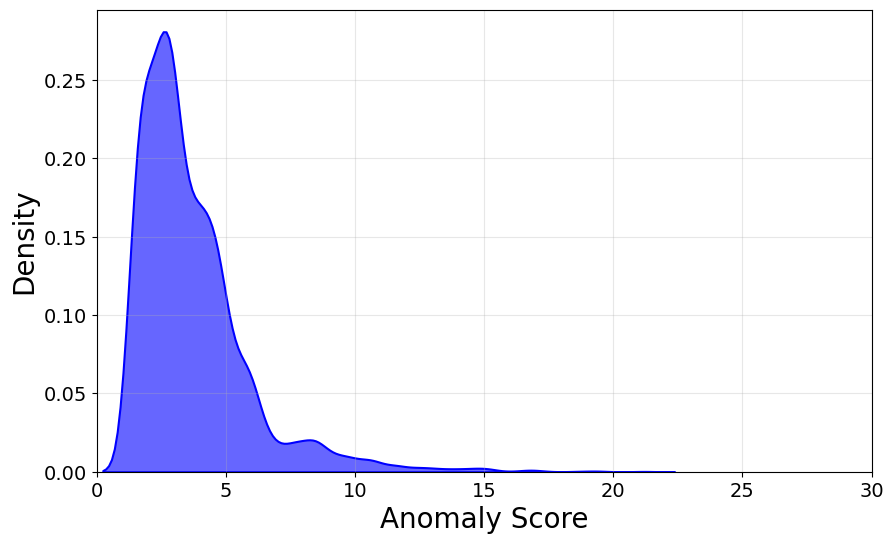

In [ ]:
import seaborn as sns

# Plot the anomaly score
dummy_flight_1.plot(y = "anomaly_score")
def plot_score(var, xlabel, xlimit):
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=bn_sample,
        x=var,      
        fill=True,
        color="blue",
        alpha=0.6,
        linewidth=1.5
    )

    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel("Density",fontsize = 20)
    plt.xlim(xlimit[0], xlimit[1])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True, alpha=0.3)

plot_score("anomaly_score", "Anomaly Score",(0,30))
plt.show()

In [ ]:
# Plot the denisty of anomaly scores across normal conditions
def plot_score(var, xlabel, xlimit):
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=bn_sample,
        x=var,      
        fill=True,
        color="blue",
        alpha=0.6,
        linewidth=1.5
    )

    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel("Density",fontsize = 20)
    plt.xlim(xlimit[0], xlimit[1])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True, alpha=0.3)

plot_score("anomaly_score", "Anomaly Score",(0,30))
plt.show()

## Autoencoder

In [ ]:
import pandas as pd
df = pd.read_csv("model_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166612 entries, 0 to 1166611
Data columns (total 36 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Unnamed: 0.1               1166612 non-null  int64  
 1   Unnamed: 0                 1166612 non-null  int64  
 2   time                       1166612 non-null  int64  
 3   icao24                     1166612 non-null  object 
 4   lat                        1166612 non-null  float64
 5   lon                        1166612 non-null  float64
 6   velocity                   1166612 non-null  float64
 7   heading                    1166612 non-null  float64
 8   vertrate                   1166612 non-null  float64
 9   onground                   1166612 non-null  bool   
 10  alert                      1166612 non-null  bool   
 11  spi                        1166612 non-null  bool   
 12  baroaltitude               1166612 non-null  float64
 13  geoaltitude 

In [ ]:
# tanh is the way to go
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow import keras
import tensorflow as tf

# Get rid of unwanted columns
cols_to_drop = [
                'icao24',  
                'alert', 
                'spi', 
                'datetime',
                'Unnamed: 0.1',
                'Unnamed: 0',
                'lastposupdate',
                'lastcontact',
                'hour',
                'minute',
                'day',
                'current_wx1_symbol',
                'current_wx2_symbol',
                'current_wx3_symbol',
                'geoaltitude',
                'air_temperature',
                'altimeter',
                'elevation',
                'visibility',
                'cloud_coverage',
                'onground',
                'time_diff',
                'dist_from_KCLT_ft',
                'air_pressure_at_sea_level',
                'time',
                'flight_phase'




]

# Scale X
X = df.drop(columns=cols_to_drop)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
features = X.columns

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166612 entries, 0 to 1166611
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   lat                    1166612 non-null  float64
 1   lon                    1166612 non-null  float64
 2   velocity               1166612 non-null  float64
 3   heading                1166612 non-null  float64
 4   vertrate               1166612 non-null  float64
 5   baroaltitude           1166612 non-null  float64
 6   bearing_to_airport     1166612 non-null  float64
 7   wind_direction         1166612 non-null  float64
 8   wind_speed             1166612 non-null  float64
 9   dew_point_temperature  1166612 non-null  float64
dtypes: float64(10)
memory usage: 89.0 MB


In [ ]:
import json

# Build an autoencoder function to run multiple configs
def build_autoencoder(input_dim, hidden_units1, hidden_units2, encoding_dim, l1=1e-4):
    # Encoder
    input_layer = keras.Input(shape=(input_dim,))
    x = keras.layers.Dense(hidden_units1, activation='tanh')(input_layer)
    x = keras.layers.Dense(hidden_units2, activation='tanh')(x)
    encoded = keras.layers.Dense(encoding_dim, activation='tanh',
                                 activity_regularizer=keras.regularizers.L1(l1))(x)
    
    # Decoder
    x = keras.layers.Dense(hidden_units2, activation='tanh')(encoded)
    x = keras.layers.Dense(hidden_units1, activation='tanh')(x)
    decoded = keras.layers.Dense(input_dim, activation='linear')(x)

    autoencoder = keras.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


input_dim = X_scaled.shape[1]

configs = [
        (10, 8, 6, "45"),
       

]


# save history for later
for hidden_units1, hidden_units2, encoding_dim, name in configs:
    autoencoder = build_autoencoder(input_dim, hidden_units1, hidden_units2, encoding_dim)
    history = autoencoder.fit(
        X_scaled, X_scaled,
        epochs=10,
        batch_size=64,
        validation_split=0.3,
        verbose=1
    )
    autoencoder.save(f"autoencoder_{name}.keras")
    with open(f"autoencoder_{name}_history.json", "w") as f:
        json.dump(history.history, f)

Epoch 1/10
12760/12760 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.1647 - val_loss: 0.1774
Epoch 2/10
 8339/12760 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0856

KeyboardInterrupt: 

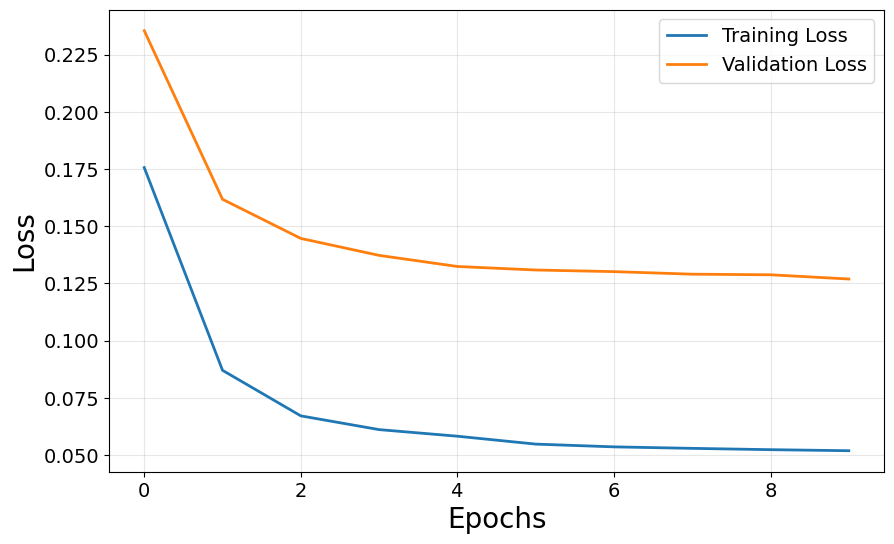

In [ ]:
import matplotlib.pyplot as plt
hist = pd.read_json("autoencoder_45_history.json")
import matplotlib.pyplot as plt

# Get loss values
train_loss = hist["loss"]
val_loss = hist["val_loss"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)

plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True, alpha = .3)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model, Model
import numpy as np

# I didn't know how to save the latent layer name so this helped
autoencoder = load_model("autoencoder_45.keras")

# Dummy input to get the layer name
dummy_input = np.zeros((1, 10))

# Run a forward pass to build layer shapes
_ = autoencoder.predict(dummy_input)

# Check shapes
for layer in autoencoder.layers:
    try:
        intermediate_model = Model(inputs=autoencoder.input, outputs=layer.output)
        output = intermediate_model.predict(dummy_input)
        print(layer.name, output.shape)
    except Exception as e:
        print(layer.name, "Error:", e)





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
input_layer_1 (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
dense_6 (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
dense_7 (1, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
dense_8 (1, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
dense_9 (1, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
dense_10 (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
dense_11 (1, 10)


In [ ]:
# Load the encoder
encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("dense_8").output
)

In [ ]:
# Predict the Latent vector
latent_X = encoder.predict(X_scaled)

# Mean vector
mean_vector = np.mean(latent_X, axis=0)

# Covariance matrix
cov_matrix = np.cov(latent_X, rowvar=False)

# Inverse covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

36457/36457 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step


In [ ]:
from scipy.spatial.distance import mahalanobis

# Compute Mahalanobis Distances
m_distances = np.array([
    mahalanobis(row, mean_vector, inv_cov_matrix)
    for row in latent_X
])

# Add distances to X_scaled DataFrame if you want
X_df = pd.DataFrame(X_scaled, columns=X.columns)  # replace feature_names with your column names
df['mahalanobis_distance'] = m_distances

In [ ]:
# Drop some columns to read easily
cols_to_drop = [
                 
                'alert', 
                'spi', 
                'datetime',
                'Unnamed: 0.1',
                'Unnamed: 0',
                'lastposupdate',
                'lastcontact',
                'hour',
                'minute',
                'day',
                'current_wx1_symbol',
                'current_wx2_symbol',
                'current_wx3_symbol',
                'geoaltitude',
                'air_temperature',
                'altimeter',
                'elevation',
                'visibility',
                'cloud_coverage',
                'onground',
                'time_diff',
                'dist_from_KCLT_ft',
                'air_pressure_at_sea_level',
                'flight_phase'
]
# df = df.drop(columns = cols_to_drop)
pd.set_option("display.max_rows", 100)
df.nlargest(100,'mahalanobis_distance').loc[df['velocity'] > 400].count()

time                     3
icao24                   3
lat                      3
lon                      3
velocity                 3
heading                  3
vertrate                 3
baroaltitude             3
bearing_to_airport       3
wind_direction           3
wind_speed               3
dew_point_temperature    3
mahalanobis_distance     3
dtype: int64

In [ ]:
# Group by time again and take the values only an hour away
df = df.sort_values(["icao24", "time"])
df["time_diff"] = df.groupby("icao24")["time"].diff().fillna(0)
df["flight_id"] = (df["time_diff"] > 3600).cumsum() 

# Get the scores for flights in the 99th percentils
flight_scores = (
    df.groupby(["icao24", "flight_id"])["mahalanobis_distance"]
      .agg(["mean", "max", lambda x: np.percentile(x, 99)])
      .rename(columns={"<lambda_0>": "p99"})
      .reset_index()
)
flight_scores.rename(columns={"<lambda_0>": "p99"}, inplace=True)
flight_scores = flight_scores.reset_index()
flight_scores['icao24'].value_counts()
cutoff_99 = np.percentile(df["mahalanobis_distance"], 99)
print("99th percentile cutoff for Mahalanobis distance:", cutoff_99)


99th percentile cutoff for Mahalanobis distance: 3.971911531816416


In [ ]:
# Identify some weird flights
df['time'] = pd.to_datetime(df['time'], unit = 's')
df.loc[(df['mahalanobis_distance'] >= 2) & (df['vertrate'] >= 15) & (df['icao24'] == 'c06a8b')].tail(200)

Unnamed: 0.1  Unnamed: 0                time  icao24        lat  \
992527        992566     2435586 2022-06-20 19:02:40  c06a8b  35.251030   
992557        992596     2435617 2022-06-20 19:02:50  c06a8b  35.257874   
992604        992643     2435638 2022-06-20 19:03:00  c06a8b  35.266393   
992628        992667     2435669 2022-06-20 19:03:10  c06a8b  35.276075   
992653        992692     2435710 2022-06-20 19:03:20  c06a8b  35.285934   
992673        992712     2435749 2022-06-20 19:03:30  c06a8b  35.297769   
992708        992747     2435785 2022-06-20 19:03:40  c06a8b  35.309593   
992755        992794     2435796 2022-06-20 19:03:50  c06a8b  35.321650   
992785        992824     2435824 2022-06-20 19:04:00  c06a8b  35.333614   
992823        992862     2435863 2022-06-20 19:04:10  c06a8b  35.345485   
992833        992872     2435909 2022-06-20 19:04:20  c06a8b  35.357123   
992879        992918     2435941 2022-06-20 19:04:30  c06a8b  35.368469   
992934        992973     2435966 2022-06-20 19:04:40  c06a8b  35.380646   
992951        992990     2436011 2022-06-20 19:04:50  c06a8b  35.391174   
993261        993300     2436317 2022-06-20 19:06:20  c06a8b  35.501249   
993294        993333     2436374 2022-06-20 19:06:30  c06a8b  35.513445   
993352        993391     2436389 2022-06-20 19:06:40  c06a8b  35.526154   
993364        993403     2436444 2022-06-20 19:06:50  c06a8b  35.537933   
993416        993455     2436495 2022-06-20 19:07:00  c06a8b  35.548918   
993467        993506     2436504 2022-06-20 19:07:10  c06a8b  35.562881   
993499        993538     2436577 2022-06-20 19:07:20  c06a8b  35.575287   
993560        993599     2436591 2022-06-20 19:07:30  c06a8b  35.587231   
993562        993601     2436642 2022-06-20 19:07:40  c06a8b  35.600219   
993615        993654     2436682 2022-06-20 19:07:50  c06a8b  35.612183   
993671        993710     2436707 2022-06-20 19:08:00  c06a8b  35.624472   
993701        993740     2436781 2022-06-20 19:08:10  c06a8b  35.636261   
993745        993784     2436795 2022-06-20 19:08:20  c06a8b  35.649424   
993767        993806     2436845 2022-06-20 19:08:30  c06a8b  35.661942   
993818        993857     2436898 2022-06-20 19:08:40  c06a8b  35.674896   
993865        993904     2436920 2022-06-20 19:08:50  c06a8b  35.687504   
993897        993936     2436977 2022-06-20 19:09:00  c06a8b  35.700166   
993957        993996     2436994 2022-06-20 19:09:10  c06a8b  35.712735   

              lon    velocity     heading   vertrate  onground  ...  \
992527 -80.961115  178.044373  321.842773  30.933334     False  ...   
992557 -80.967236  185.800379  323.315126  26.666668     False  ...   
992604 -80.971459  203.393061  349.518782  36.266668     False  ...   
992628 -80.973037  210.489236  353.178848  34.133334     False  ...   
992653 -80.974560  218.672578  352.907483  26.666668     False  ...   
992673 -80.976251  239.759536  353.052828  19.200001     False  ...   
992708 -80.978004  250.921502  352.903306  21.333334     False  ...   
992755 -80.979640  258.630190  353.561950  44.800001     False  ...   
992785 -80.981218  258.773211  355.567332  51.200002     False  ...   
992823 -80.980225  256.461659    9.425594  62.933335     False  ...   
992833 -80.977829  254.700978    8.352794  49.066668     False  ...   
992879 -80.976048  254.282499    7.683982  54.400002     False  ...   
992934 -80.973930  257.389936    7.815294  37.333335     False  ...   
992951 -80.972214  262.344359    7.666804  23.466667     False  ...   
993261 -80.954278  268.291899    7.495858  20.266667     False  ...   
993294 -80.952350  271.266534    7.413196  38.400001     False  ...   
993352 -80.950304  271.397370    7.622545  44.800001     False  ...   
993364 -80.948353  269.415180    7.678964  48.000002     False  ...   
993416 -80.946564  268.424184    7.707486  40.533335     False  ...   
993467 -80.944347  270.147250    7.230243  38.400001     False  ...   
993499 -80.942345  269.415180    7.678964

In [ ]:
start = '2022-03-28 03:26:20'
end = '2022-03-28 03:30:50'

# Mean flight Mahalanobis Distance
df_timeframe = df[(df['time'] >= start) & (df['time'] <= end) & (df['icao24'] == 'a6f6dd')]
print(df_timeframe['mahalanobis_distance'].mean())



4.0948110043644


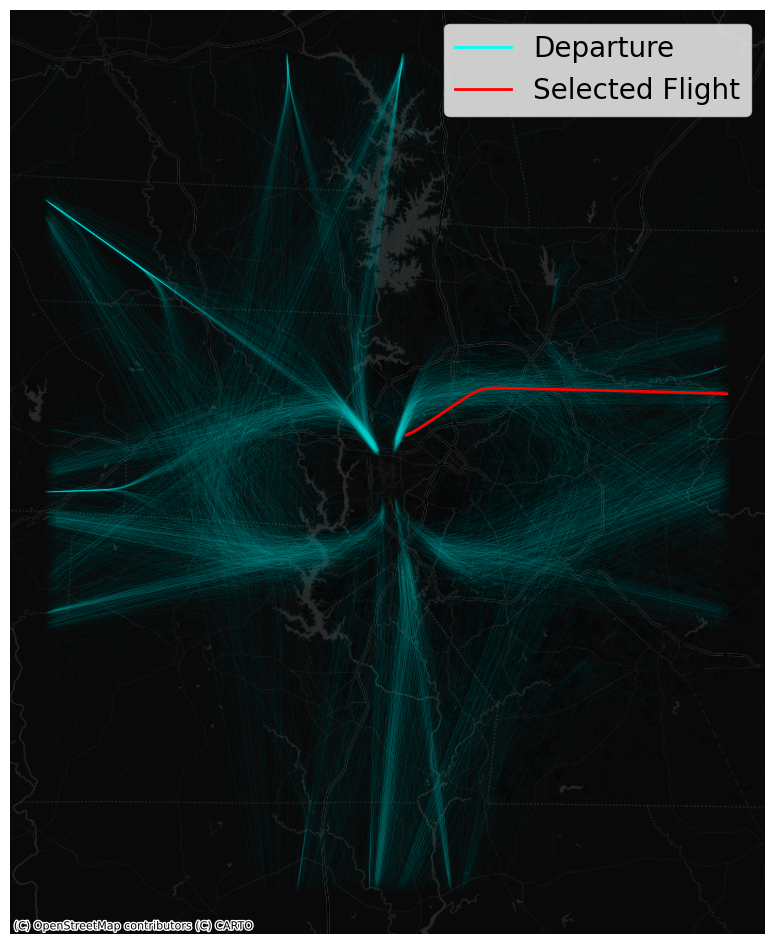

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

# Convert df_timeframe to GeoDataFrame
flight_gdf = gpd.GeoDataFrame(
    df_timeframe,
    geometry=gpd.points_from_xy(df_timeframe["lon"], df_timeframe["lat"]),
    crs="EPSG:4326"
).sort_values("time")

# Create a LineString for the flight
flight_line = LineString(flight_gdf.geometry.tolist())
flight_line_gdf = gpd.GeoDataFrame(
    {"icao24": [df_timeframe["icao24"].iloc[0]]},
    geometry=[flight_line],
    crs="EPSG:4326"
)

# Convert both gdf_plotting and flight_line_gdf to Web Mercator
gdf_plotting = gdf.to_crs(epsg=3857)
flight_line_gdf = flight_line_gdf.to_crs(epsg=3857)

# Filter arrivals and departures
mask = gdf_plotting["flight_phase"].isin(["Departure"])
gdf_filtered = gdf_plotting[mask]
colors = gdf_filtered["flight_phase"].map({
    
    "Departure": "cyan"
})

# Plot
ax = gdf_filtered.plot(
    figsize=(12, 12),
    linewidth=0.08,
    alpha=0.15,
    color=colors
)

# Overlay your single flight path in bright red
flight_line_gdf.plot(ax=ax, color="red", linewidth=2, label="Selected Flight")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=phase) 
           for phase, color in {"Departure": "cyan"}.items()]
handles.append(plt.Line2D([0], [0], color="red", lw=2, label="Selected Flight"))
ax.legend(handles=handles, loc='upper right', fontsize=20)

ax.set_axis_off()
plt.savefig("flight_paths_by_phase_with_selected.png", dpi=500, bbox_inches="tight", transparent=True)
plt.show()

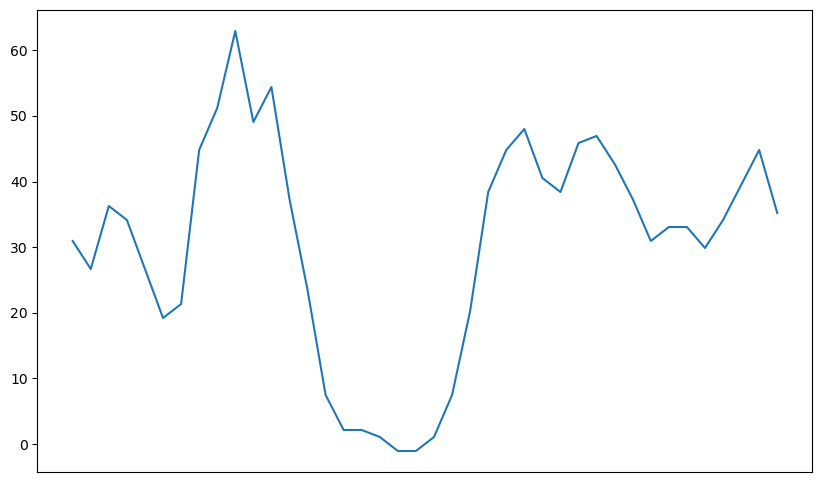

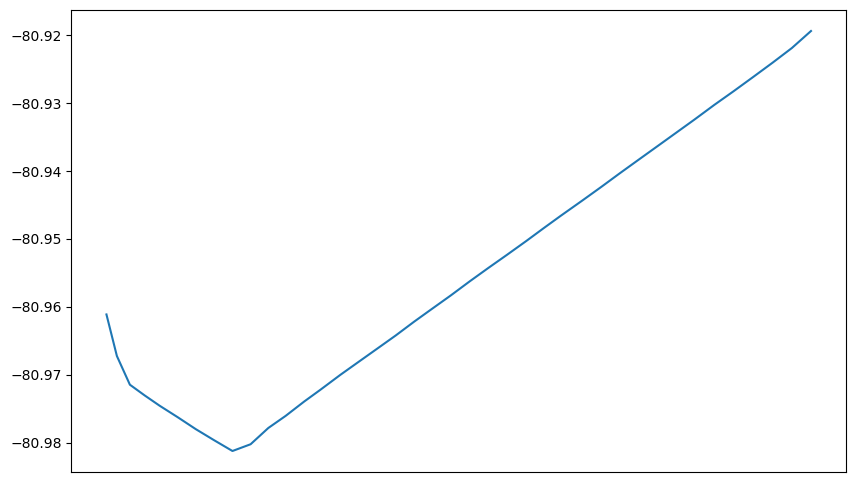

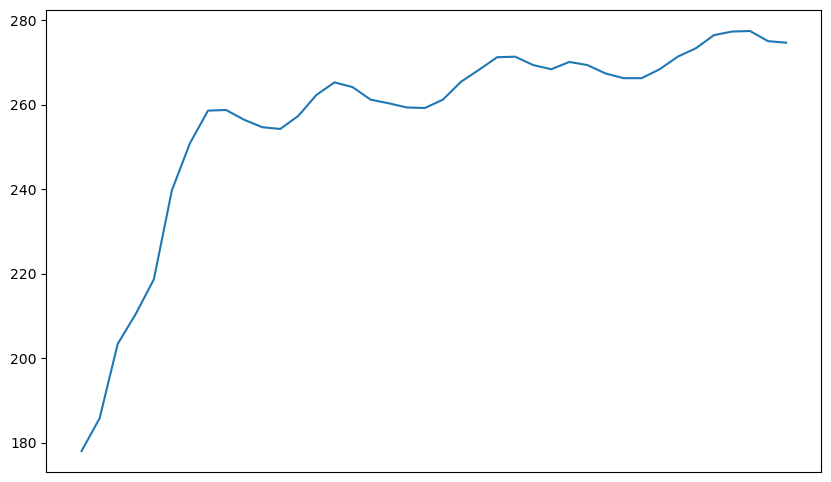

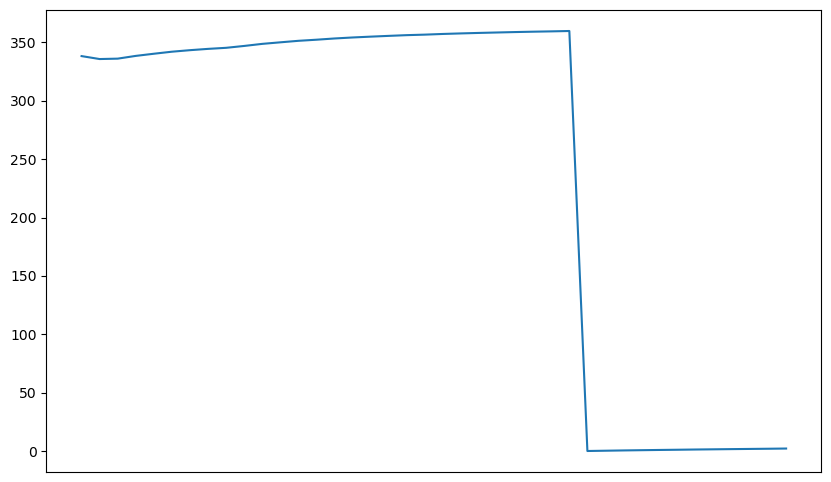

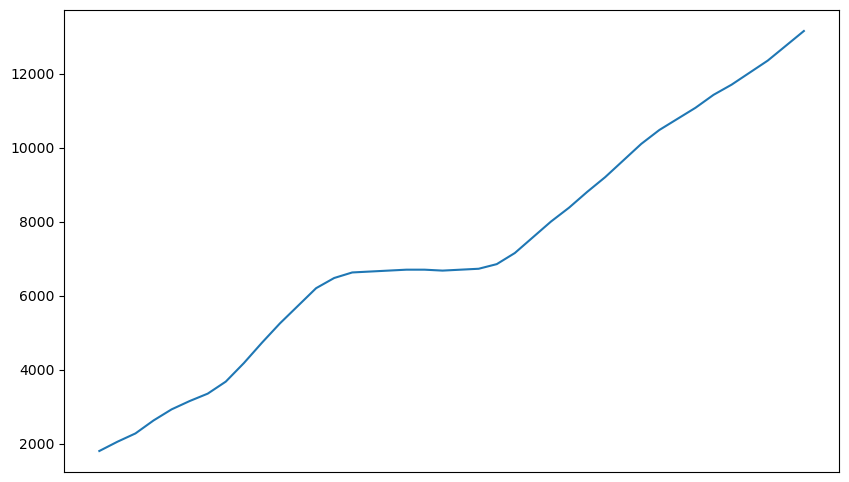

In [ ]:
# Playing aroundd with some plots to determine why a flight was anomalous
def plot_flight(x,y):

    plt.figure(figsize = (10,6))
    plt.plot(x,y)
    plt.xticks([])
    plt.yticks()
    plt.show()

plot_flight(df_timeframe['time'],df_timeframe['vertrate'])
plot_flight(df_timeframe['lat'],df_timeframe['lon'])
plot_flight(df_timeframe['time'],df_timeframe['velocity'])
plot_flight(df_timeframe['time'], df_timeframe['bearing_to_airport'])
plot_flight(df_timeframe['time'], df_timeframe['baroaltitude'])


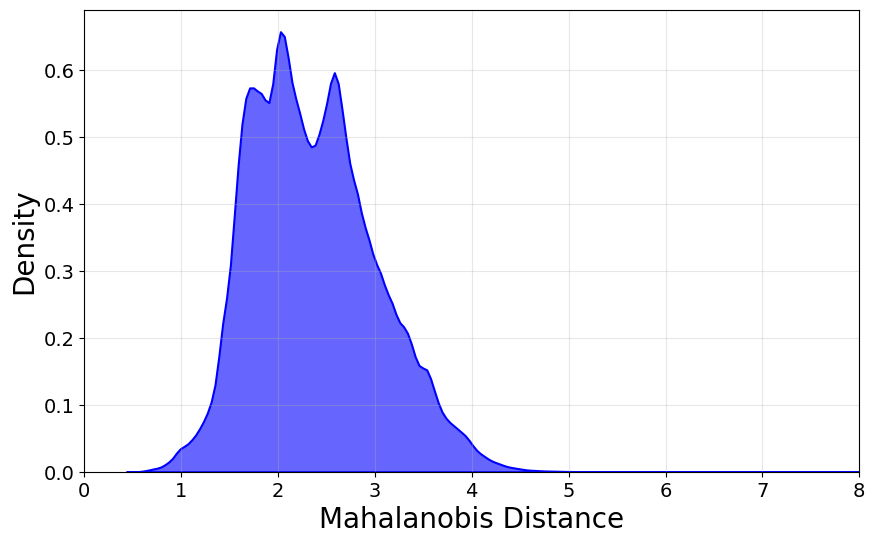

In [ ]:
# Density plot of Mahalanobis Distance
def plot_dens(var, xlabel, xlimit):
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=X_df,
        x=var,      
        fill=True,
        color="blue",
        alpha=0.6,
        linewidth=1.5
    )

    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel("Density",fontsize = 20)
    plt.xlim(xlimit[0], xlimit[1])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True, alpha=0.3)

plot_dens("mahalanobis_distance", "Mahalanobis Distance",(0,8))
plt.show()

## Extra
I was playing around with another fake flight, decided to go with a real one

In [ ]:
import pandas as pd

n_maintain = 60      # steps maintaining altitude
n_fall = 60          # steps in dive
alt_start = 20000
v_start = 500
dv = 10
dt = 1
vertrate = -400

icao_id = 'c06a7b'
df_icao = df.loc[df['icao24'] == icao_id]
df_icao = df_icao[:6]

dummy_flight_2 = pd.DataFrame(columns=X.columns)

# Only apply linspace to numeric columns
for col in df_icao.columns:
    if pd.api.types.is_numeric_dtype(df_icao[col]):
        dummy_flight_2[col] = np.linspace(df_icao[col].min(), df_icao[col].max(), 120)
    else:
        # For non-numeric columns, just repeat the first value or fill with None
        dummy_flight_2[col] = [df_icao[col].iloc[0]] * 120 if len(df_icao[col]) > 0 else [None] * 120

# v_end = []
# for i in range(n_fall):
#     v_end.append(v_start + dv)    
dummy_flight_2["velocity"] = [500] *(n_maintain + n_fall) 

# Vertical rate
dummy_flight_2["vertrate"] = ([0] * n_maintain) + ([vertrate] * n_fall)


# Altitude
alt_end = []
for i in range(n_fall):
    alt_end.append(alt_start + (vertrate * i))
dummy_flight_2["baroaltitude"] = [alt_start] * (n_maintain) + alt_end
dummy_flight_2['flight_phase_Arrival'] = False
dummy_flight_2['flight_phase_Departure'] = False
dummy_flight_2['flight_phase_Cruising'] = True
dummy_flight_2 = dummy_flight_2.iloc[:, :10]
dummy_flight_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    120 non-null    float64
 1   lon                    120 non-null    float64
 2   velocity               120 non-null    int64  
 3   heading                120 non-null    float64
 4   vertrate               120 non-null    int64  
 5   baroaltitude           120 non-null    int64  
 6   bearing_to_airport     120 non-null    float64
 7   wind_direction         120 non-null    float64
 8   wind_speed             120 non-null    float64
 9   dew_point_temperature  120 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 9.5 KB


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


<Axes: >

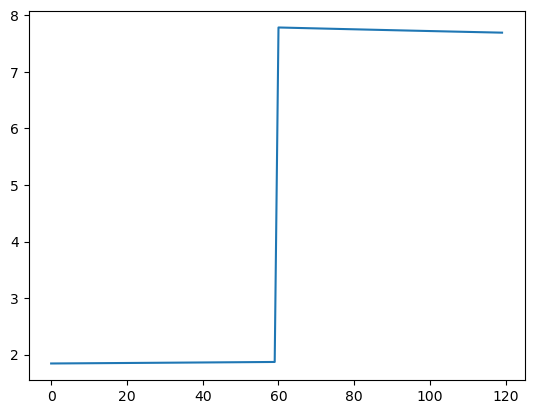

In [ ]:
from scipy.spatial.distance import mahalanobis

# Assume dummy_flight_2 is your new flight dataframe with same 10 features
df_flight_scaled = scaler.transform(dummy_flight_2)  # same scaler used for X_scaled
latent_flight = encoder.predict(df_flight_scaled)
# Vectorized computation
diff = latent_flight - mean_vector
m_distances = np.array([
    mahalanobis(x, mean_vector, inv_cov_matrix) 
    for x in latent_flight
])

# Add to dataframe
dummy_flight_2['mahalanobis_distance'] = m_distances
dummy_flight_2['mahalanobis_distance'].plot()

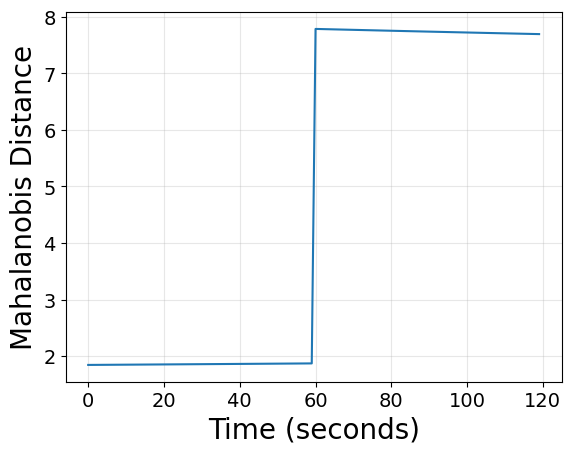

In [ ]:
plt.plot(dummy_flight_2['mahalanobis_distance'])
plt.ylabel("Mahalanobis Distance", fontsize=20)
plt.xlabel("Time (seconds)", fontsize=20)
plt.tick_params(labelsize=14)
plt.grid(True, alpha = .3)
plt.show()

In [ ]:
print(dummy_flight_2[X.columns].shape, X_scaled.shape[1])

(120, 10) 10


In [ ]:
dummy_scaled = scaler.transform(dummy_flight_2[X.columns])
latent_dummy = encoder.predict(dummy_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
# 1. Get latent vectors for normal flights
latent_normal = encoder.predict(X_scaled)  # all normal training samples

# 2. Compute mean and covariance
mu = np.mean(latent_normal, axis=0)
cov = np.cov(latent_normal, rowvar=False) + np.eye(latent_normal.shape[1]) * 1e-6
cov_inv = np.linalg.inv(cov)

# 3. Compute latent for your test flight
latent_test = encoder.predict(scaler.transform(dummy_flight_2[X.columns]))

# 4. Mahalanobis distance per timestep
diff = latent_test - mu
mahal_distances = np.array([np.sqrt(np.dot(np.dot(d, cov_inv), d.T)) for d in diff])

dummy_flight_2["mahalanobis"] = mahal_distances



36457/36457 ━━━━━━━━━━━━━━━━━━━━ 24s 649us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1166611    6.645141e-08
Name: mahalanobis, dtype: float64


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)
icao_id = 'c06a7b'
df_icao = df.loc[df['icao24'] == icao_id]
df_icao = df_icao[:6]
print(df_icao)


     Unnamed: 0.1  Unnamed: 0        time  icao24        lat        lon  \
1               1     1326335  1646611210  c06a7b  34.835738 -80.607605   
33             33     1326360  1646611220  c06a7b  34.814758 -80.609604   
75             75     1326372  1646611230  c06a7b  34.793980 -80.611610   
88             88     1326404  1646611240  c06a7b  34.773498 -80.613613   
129           129     1326426  1646611250  c06a7b  34.752642 -80.615616   
146           146     1326450  1646611260  c06a7b  34.732019 -80.617561   

       velocity     heading  vertrate  onground  alert    spi  baroaltitude  \
1    448.366729  184.477112  0.000000     False  False  False  36025.001153   
33   448.445897  184.604487 -1.066667     False  False  False  36025.001153   
75   448.445897  184.604487  0.000000     False  False  False  36025.001153   
88   448.366729  184.477112  0.000000     False  False  False  36025.001153   
129  447.369790  184.487110  1.066667     False  False  False  36025.001153   


In [ ]:
# Load the encoder
encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("dense_57").output
)

# Define a function to run a sample
def run_sample(autoencoder, encoder, scaler, sample_df, features):
    
    # Scale the sample with the same function or it won't work
    sample_scaled = scaler.transform(sample_df[features])
    latent = encoder.predict(sample_scaled)
    reconstructed = autoencoder.predict(sample_scaled)
    error = np.mean(np.abs(sample_scaled - reconstructed), axis=1)
    return latent, reconstructed, error

sample_data = X.iloc[-1].to_frame().T
features = list(X.columns)

latent, reconstructed, error = run_sample(autoencoder, encoder, scaler, sample_data, features)
reconstructed_original = scaler.inverse_transform(reconstructed)
print("Latent:", latent)
print("Reconstructed:", reconstructed_original)
print("Error:", error)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Latent: [[1.10764056e-07 8.15224297e-08 9.90179956e-08]]
Reconstructed: [[ 1.64984358e+09  3.52673454e+01 -8.09283600e+01  2.57080688e+02
   1.78018936e+02 -1.77343392e+00  8.63522291e-06  1.17944775e+04
   7.19460510e+02  9.73596094e+04  1.90825546e+02  1.93276505e+02
   6.93028831e+00  4.87824869e+00  1.02057574e+03  4.94827926e-01
   3.38560373e-01  1.65911630e-01]]
Error: [0.23719793]


In [ ]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from tensorflow.keras.models import Model

df["datetime"] = pd.to_datetime(df["datetime"])

# Filter flight
icao24 = 'fb1f38'
start_time = "2022-03-28 02:26:50"
end_time = "2022-03-28 02:33:20"

flight_df = df[
    (df['icao24'] == icao24) &
    (df["datetime"] >= start_time) &
    (df["datetime"] <= end_time)
].sort_values("datetime").reset_index(drop=True)


flight_df = pd.get_dummies(flight_df, columns=["flight_phase"])

flight_df["flight_phase_Arrival"].head()

new_cols = ["flight_phase_Cruising", "flight_phase_Departure"]
flight_df[new_cols] = False

# Take last row, modify, and append
last_row = flight_df.iloc[-1].copy()
last_row["velocity"] = last_row["velocity"] + 500
last_row["datetime"] = last_row["datetime"] + pd.Timedelta(seconds=10)
flight_df = pd.concat([flight_df, last_row.to_frame().T], ignore_index=True)

# Scale the sample with the same function or it won't work
sample_scaled = scaler.transform(flight_df[features])
latent_vectors = encoder.predict(sample_scaled)

mu = np.mean(latent_vectors, axis=0)          # mean vector
cov = np.cov(latent_vectors, rowvar=False)   # covariance matrix
cov += np.eye(cov.shape[0]) * 1e-6
cov_inv = np.linalg.inv(cov)

def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))

mahal_distances = np.array([mahalanobis_distance(z, mu, cov_inv) for z in latent_vectors])

flight_df["mahalanobis"] = mahal_distances
print(flight_df[["velocity", "datetime", "mahalanobis"]].tail())


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
      velocity             datetime  mahalanobis
36  154.323844  2022-03-28 02:32:50     0.000002
37  154.323844  2022-03-28 02:33:00     0.000002
38  154.323844  2022-03-28 02:33:10     0.000002
39  154.323844  2022-03-28 02:33:20     0.000002
40  654.323844  2022-03-28 02:33:30     0.000005


In [ ]:
paths_df = pd.read_csv("flight_paths.csv")
paths_df["start_time"] = pd.to_datetime(paths_df["start_time"])
paths_df["end_time"] = pd.to_datetime(paths_df["end_time"])
paths_df["duration"] = paths_df["end_time"] - paths_df["start_time"]

one_hour = pd.Timedelta(hours=1)
flights_around_one_hour = paths_df[
    (paths_df["duration"] >= one_hour) &
    (paths_df["duration"] <= one_hour + pd.Timedelta(minutes=30))  # optional ±5 min
]

# Check the result
flights_around_one_hour[["icao24", "start_time", "end_time", "duration"]]

icao24          start_time            end_time        duration
559    a02dd2 2022-03-21 14:22:00 2022-03-21 15:30:10 0 days 01:08:10
571    a02dd2 2022-06-20 15:17:10 2022-06-20 16:36:20 0 days 01:19:10
690    a03ce6 2022-06-27 17:58:40 2022-06-27 19:27:30 0 days 01:28:50
1066   a06967 2022-06-06 12:17:00 2022-06-06 13:24:00 0 days 01:07:00
3363   a27499 2022-06-13 21:49:40 2022-06-13 22:59:30 0 days 01:09:50
4188   a35bf7 2022-06-27 22:29:10 2022-06-27 23:34:10 0 days 01:05:00
5248   a44eeb 2022-03-14 16:46:20 2022-03-14 18:11:50 0 days 01:25:30
5632   a4c434 2022-03-07 18:29:40 2022-03-07 19:54:10 0 days 01:24:30
5804   a4fc50 2022-03-28 16:16:10 2022-03-28 17:28:00 0 days 01:11:50
6029   a539a6 2022-06-20 20:01:40 2022-06-20 21:26:10 0 days 01:24:30
6286   a585f8 2022-03-14 18:13:10 2022-03-14 19:25:20 0 days 01:12:10
11609  a83861 2022-06-20 12:54:40 2022-06-20 14:22:10 0 days 01:27:30
12861  a8e32b 2022-06-27 17:53:10 2022-06-27 19:23:10 0 days 01:30:00
13032  a91986 2022-03-28 15:54:20 2022-03-28 17:22:10 0 days 01:27:50
13984  a9b20d 2022-06-06 20:26:00 2022-06-06 21:43:20 0 days 01:17:20
14247  a9e701 2022-06-20 15:01:30 2022-06-20 16:31:10 0 days 01:29:40
14340  a9f9db 2022-06-20 13:12:10 2022-06-20 14:25:00 0 days 01:12:50
14341  a9f9db 2022-06-20 20:00:40 2022-06-20 21:22:40 0 days 01:22:00
14680  aa4b78 2022-06-06 17:18:00 2022-06-06 18:33:40 0 days 01:15:40
15169  aacd46 2022-03-21 17:00:50 2022-03-21 18:30:30 0 days 01:29:40
15203  aadc7a 2022-03-21 17:16:40 2022-03-21 18:27:40 0 days 01:11:00
15763  ab383e 2022-03-21 14:07:00 2022-03-21 15:32:30 0 days 01:25:30
19789  adfd7d 2022-03-28 13:52:20 2022-03-28 15:07:30 0 days 01:15:10